<a href="https://colab.research.google.com/github/AImSecure/Laboratory3/blob/main/lab/notebooks/Lab3_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratory 3 — Anomaly Detection

**Course:** AI and Cybersecurity  
**Project:** Supervised vs Unsupervised Anomaly Detection  
**Objective:** Apply Shallow and Deep Learning anomaly detection techniques to build an Intrusion Detection System (IDS).

> **Key Constraint:** We do not use labels to train supervised models directly. Instead, we evaluate whether unsupervised algorithms can automatically detect anomalous patterns.

## Setup

In [2]:
# --- Check Python and pip versions ---
!python --version
!pip install --upgrade pip

Python 3.12.12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [3]:






# --- Install required libraries ---
!pip install torch
!pip install numpy pandas scikit-learn matplotlib seaborn
!pip install tqdm

In [4]:
# --- Import libraries ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix,
    f1_score, silhouette_score, silhouette_samples
)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.compose import ColumnTransformer
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import copy

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set visual style
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)

In [5]:
# Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

### Colab Pro

In [6]:
# --- Check GPU availability ---
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec 17 14:15:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
# --- Check RAM availability ---
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


### Paths setup


In [8]:
# --- Mount Google Drive (for Google Colab users) ---
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# --- Define Paths ---
group = 'AImSecure'
laboratory = 'Laboratory3'

base_path = '/content/drive/MyDrive/'
project_path = base_path + f'Projects/{group}/{laboratory}/'
data_path = project_path + 'data/'
results_path = project_path + 'results/'

# Ensure directories exist
os.makedirs(project_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)

print(f"Project path: {project_path}")
print(f"Data path: {data_path}")
print(f"Results path: {results_path}")

Project path: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/
Data path: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/data/
Results path: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/


In [10]:
# --- Helper function for saving plots ---

def save_plot(fig: plt.Figure, filename: str, path: str = "./plots/", fmt: str = "png", dpi: int = 300, close_fig: bool = False) -> None:
    """
    Save a Matplotlib figure to a specified directory.

    Args:
        fig (plt.Figure): Matplotlib figure object to save.
        filename (str): Name of the file to save (without extension).
        path (str, optional): Directory path to save the figure. Defaults to './plots/'.
        fmt (str, optional): File format for the saved figure. Defaults to 'png'.
        dpi (int, optional): Dots per inch for the saved figure. Defaults to 300.
        close_fig (bool, optional): Whether to close the figure after saving. Defaults to False.

    Returns:
        None
    """
    os.makedirs(path, exist_ok=True)
    full_path = os.path.join(path, f"{filename}.{fmt}")
    fig.savefig(full_path, bbox_inches='tight', pad_inches=0.1, dpi=dpi, format=fmt)

    if close_fig:
        plt.close(fig)

    print(f"Saved plot: {full_path}")

## Task 1 — Dataset Characterization and Preprocessing

In this task, we explore the dataset structure and prepare features for anomaly detection:
1. **Exploration** — Understand feature types and label distributions
2. **Preprocessing** — Handle categorical features, normalize numerical features
3. **Domain Analysis** — Use heatmaps to identify feature-attack correlations

In [11]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task1_plots/'
os.makedirs(save_dir, exist_ok=True)

### Explore the dataset

Before preprocessing, we explore the data to understand the available features.

In [12]:
# Load Datasets
train_df = pd.read_csv(data_path + 'train.csv')
test_df = pd.read_csv(data_path + 'test.csv')

print("Files loaded successfully.")
print(f"Train dataset shape: {train_df.shape}")
print(f"Test dataset shape:  {test_df.shape}")

Files loaded successfully.
Train dataset shape: (18831, 43)
Test dataset shape:  (5826, 43)


In [13]:
train_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,binary_label
0,0,udp,private,SF,28,0,0,3,0,0,...,0.36,0.65,0.36,0.00,0.09,0.0,0.56,0.0,dos,1
1,0,icmp,eco_i,SF,8,0,0,0,0,0,...,1.00,0.00,1.00,0.50,0.00,0.0,0.00,0.0,probe,1
2,0,tcp,daytime,S0,0,0,0,0,0,0,...,0.02,0.05,0.00,0.00,1.00,1.0,0.00,0.0,dos,1
3,0,tcp,http,SF,216,3396,0,0,0,0,...,1.00,0.00,0.14,0.02,0.00,0.0,0.00,0.0,normal,0
4,0,tcp,http,SF,348,277,0,0,0,0,...,1.00,0.00,0.01,0.07,0.00,0.0,0.00,0.0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18826,0,tcp,http,SF,328,1231,0,0,0,0,...,1.00,0.00,0.02,0.02,0.00,0.0,0.00,0.0,normal,0
18827,0,tcp,http,SF,214,928,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,normal,0
18828,0,tcp,http,SF,253,11905,0,0,0,0,...,1.00,0.00,0.01,0.02,0.00,0.0,0.00,0.0,normal,0
18829,0,tcp,uucp_path,S0,0,0,0,0,0,0,...,0.05,0.07,0.00,0.00,1.00,1.0,0.00,0.0,dos,1


In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18831 entries, 0 to 18830
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     18831 non-null  int64  
 1   protocol_type                18831 non-null  object 
 2   service                      18831 non-null  object 
 3   flag                         18831 non-null  object 
 4   src_bytes                    18831 non-null  int64  
 5   dst_bytes                    18831 non-null  int64  
 6   land                         18831 non-null  int64  
 7   wrong_fragment               18831 non-null  int64  
 8   urgent                       18831 non-null  int64  
 9   hot                          18831 non-null  int64  
 10  num_failed_logins            18831 non-null  int64  
 11  logged_in                    18831 non-null  int64  
 12  num_compromised              18831 non-null  int64  
 13  root_shell      

In [15]:
test_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,binary_label
0,0,udp,private,SF,1,0,0,0,0,0,...,0.03,0.85,1.00,0.0,0.0,0.0,0.0,0.0,normal,0
1,0,udp,private,SF,55,51,0,0,0,0,...,1.00,0.00,0.99,0.0,0.0,0.0,0.0,0.0,normal,0
2,0,tcp,login,RSTO,0,0,0,0,0,0,...,0.07,0.06,0.00,0.0,0.0,0.0,1.0,1.0,dos,1
3,0,tcp,ftp,S0,0,0,0,0,0,0,...,0.00,0.11,0.00,0.0,1.0,1.0,0.0,0.0,dos,1
4,0,tcp,courier,REJ,0,0,0,0,0,0,...,0.07,0.05,0.00,0.0,0.0,0.0,1.0,1.0,dos,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5821,0,udp,domain_u,SF,46,85,0,0,0,0,...,1.00,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal,0
5822,0,udp,domain_u,SF,45,45,0,0,0,0,...,0.89,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal,0
5823,0,udp,domain_u,SF,44,79,0,0,0,0,...,1.00,0.00,0.01,0.0,0.0,0.0,0.0,0.0,normal,0
5824,0,udp,private,SF,54,52,0,0,0,0,...,1.00,0.00,0.84,0.0,0.0,0.0,0.0,0.0,normal,0


In [16]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5826 entries, 0 to 5825
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     5826 non-null   int64  
 1   protocol_type                5826 non-null   object 
 2   service                      5826 non-null   object 
 3   flag                         5826 non-null   object 
 4   src_bytes                    5826 non-null   int64  
 5   dst_bytes                    5826 non-null   int64  
 6   land                         5826 non-null   int64  
 7   wrong_fragment               5826 non-null   int64  
 8   urgent                       5826 non-null   int64  
 9   hot                          5826 non-null   int64  
 10  num_failed_logins            5826 non-null   int64  
 11  logged_in                    5826 non-null   int64  
 12  num_compromised              5826 non-null   int64  
 13  root_shell        

In [17]:
# --- Identify Categorical and Numerical Features ---

# We exclude the label columns from the feature lists
label_cols = ['label', 'binary_label']

# Identify categorical columns (type 'object')
categorical_cols = train_df.select_dtypes(include=['object']).columns.drop(label_cols, errors='ignore').to_list()

# Identify numerical columns (any number type)
numerical_cols = train_df.select_dtypes(include=np.number).columns.drop(label_cols, errors='ignore').to_list()

print(f"\n--- Feature Types ---")
print(f"Categorical features: {categorical_cols}")
print(f"Numerical features: {len(numerical_cols)} (First 5: {numerical_cols[:5]}...)")
print(f"Label features: {label_cols}")


--- Feature Types ---
Categorical features: ['protocol_type', 'service', 'flag']
Numerical features: 38 (First 5: ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment']...)
Label features: ['label', 'binary_label']


In [18]:
for column in ['protocol_type', 'service', 'flag']:
  print(f"{column}: {train_df[column].unique()}")

protocol_type: ['udp' 'icmp' 'tcp']
service: ['private' 'eco_i' 'daytime' 'http' 'exec' 'smtp' 'ftp_data' 'ssh'
 'domain_u' 'other' 'netbios_ns' 'urp_i' 'ecr_i' 'ftp' 'discard' 'ntp_u'
 'http_443' 'telnet' 'systat' 'Z39_50' 'name' 'finger' 'iso_tsap'
 'courier' 'netstat' 'hostnames' 'csnet_ns' 'efs' 'link' 'ctf' 'supdup'
 'auth' 'X11' 'klogin' 'IRC' 'time' 'domain' 'pop_3' 'whois' 'uucp_path'
 'vmnet' 'pop_2' 'netbios_dgm' 'nntp' 'bgp' 'uucp' 'gopher' 'nnsp'
 'kshell' 'sql_net' 'urh_i' 'ldap' 'mtp' 'sunrpc' 'rje' 'echo' 'login'
 'netbios_ssn' 'imap4' 'red_i' 'printer' 'http_8001' 'pm_dump'
 'remote_job' 'shell']
flag: ['SF' 'S0' 'REJ' 'RSTO' 'RSTR' 'S2' 'S1' 'SH' 'RSTOS0' 'S3' 'OTH']


In [19]:
# --- Check Label Distribution ---
print("\n--- Attack Label Distribution (Train) ---")
print(train_df['label'].value_counts(normalize=True) * 100)

print("\n--- Binary Label Distribution (Train) ---")
print(train_df['binary_label'].value_counts(normalize=True) * 100)

print("\n--- Attack Label Distribution (Test) ---")
print(test_df['label'].value_counts(normalize=True) * 100)

print("\n--- Binary Label Distribution (Test) ---")
print(test_df['binary_label'].value_counts(normalize=True) * 100)


--- Attack Label Distribution (Train) ---
label
normal    71.414158
dos       15.469173
probe     12.155488
r2l        0.961181
Name: proportion, dtype: float64

--- Binary Label Distribution (Train) ---
binary_label
0    71.414158
1    28.585842
Name: proportion, dtype: float64

--- Attack Label Distribution (Test) ---
label
dos       44.232750
normal    36.937865
probe     18.829386
Name: proportion, dtype: float64

--- Binary Label Distribution (Test) ---
binary_label
1    63.062135
0    36.937865
Name: proportion, dtype: float64


Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task1_plots/train_multiclass_label_distribution.png


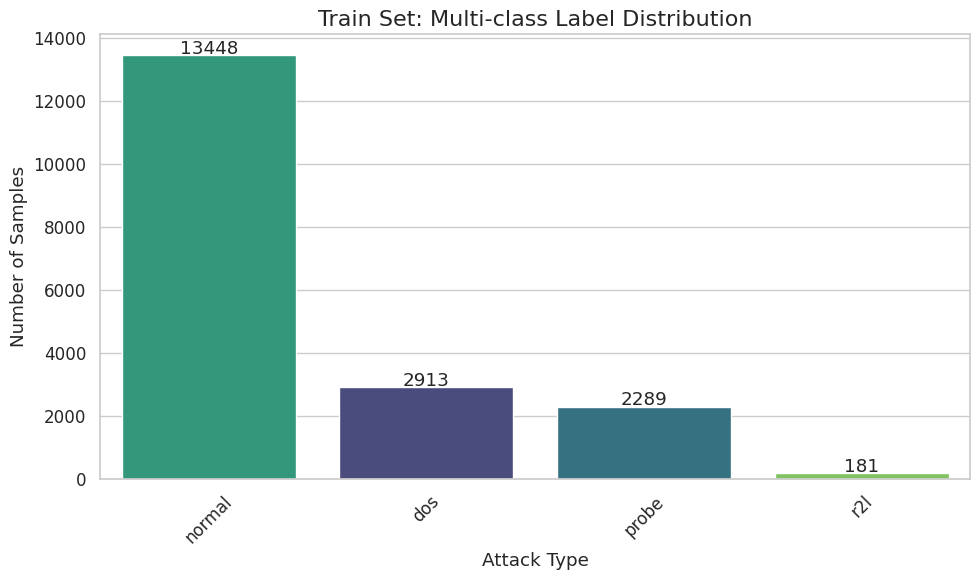

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task1_plots/train_binary_label_distribution.png


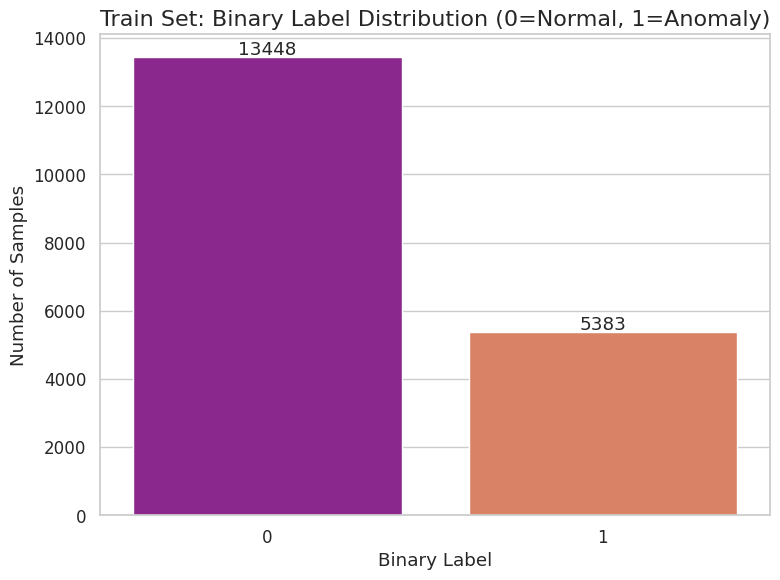

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task1_plots/test_multiclass_label_distribution.png


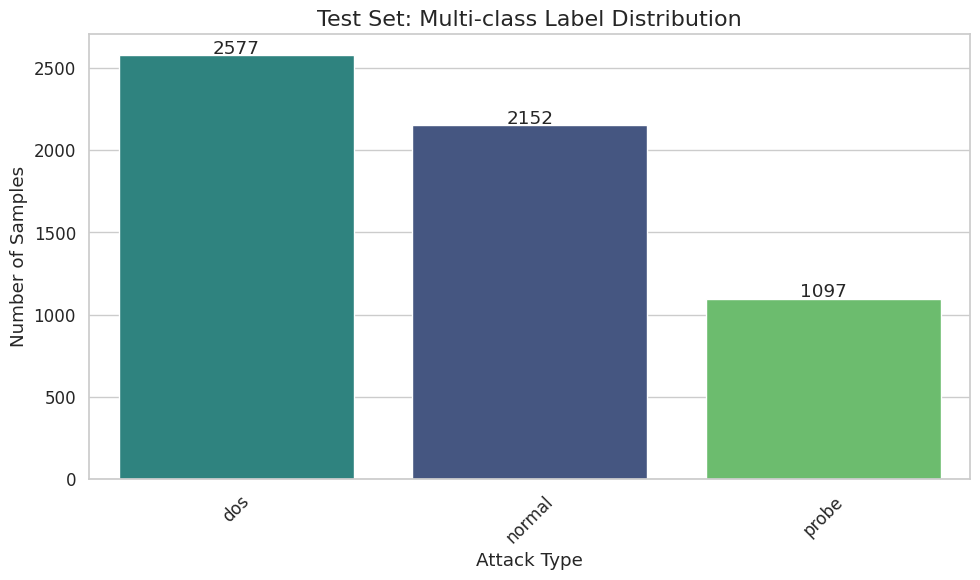

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task1_plots/test_binary_label_distribution.png


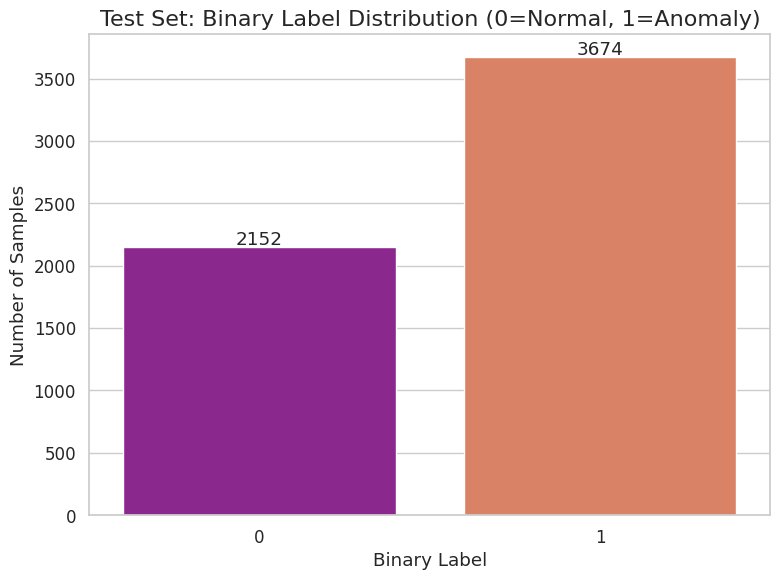

In [20]:
# Helper function to add count labels on bars
def add_counts(ax):
    for p in ax.patches:
        ax.annotate(
            f'{int(p.get_height())}',
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center',
            xytext=(0, 5),
            textcoords='offset points'
        )

# --- Plot 1: Train Set - Multi-class Label Distribution ---
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=train_df,
    x='label',
    palette='viridis',
    order=train_df['label'].value_counts().index,
    hue='label',
    legend=False
)
plt.title('Train Set: Multi-class Label Distribution', fontsize=16)
plt.xlabel('Attack Type')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
add_counts(ax)
plt.tight_layout() # Adjust layout for this specific figure
save_plot(plt.gcf(), 'train_multiclass_label_distribution', path=save_dir, close_fig=False)
plt.show()


# --- Plot 2: Train Set - Binary Label Distribution ---
plt.figure(figsize=(8, 6))
ax = sns.countplot(
    data=train_df,
    x='binary_label',
    palette='plasma',
    hue='binary_label',
    legend=False
)
plt.title('Train Set: Binary Label Distribution (0=Normal, 1=Anomaly)', fontsize=16)
plt.xlabel('Binary Label')
plt.ylabel('Number of Samples')
add_counts(ax)
plt.tight_layout()
save_plot(plt.gcf(), 'train_binary_label_distribution', path=save_dir, close_fig=False)
plt.show()


# --- Plot 3: Test Set - Multi-class Label Distribution ---
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=test_df,
    x='label',
    palette='viridis',
    order=test_df['label'].value_counts().index,
    hue='label',
    legend=False
)
plt.title('Test Set: Multi-class Label Distribution', fontsize=16)
plt.xlabel('Attack Type')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
add_counts(ax)
plt.tight_layout()
save_plot(plt.gcf(), 'test_multiclass_label_distribution', path=save_dir, close_fig=False)
plt.show()


# --- Plot 4: Test Set - Binary Label Distribution ---
plt.figure(figsize=(8, 6))
ax = sns.countplot(
    data=test_df,
    x='binary_label',
    palette='plasma',
    hue='binary_label',
    legend=False
)
plt.title('Test Set: Binary Label Distribution (0=Normal, 1=Anomaly)', fontsize=16)
plt.xlabel('Binary Label')
plt.ylabel('Number of Samples')
add_counts(ax)
plt.tight_layout()
save_plot(plt.gcf(), 'test_binary_label_distribution', path=save_dir, close_fig=False)
plt.show()

In [21]:
print("\n--- Value Counts for Training Data ---")
for col in ['protocol_type', 'service', 'flag']:
    print(f"\n{col} (Train):")
    print(train_df[col].value_counts())

print("\n--- Value Counts for Test Data ---")
for col in ['protocol_type', 'service', 'flag']:
    print(f"\n{col} (Test):")
    print(test_df[col].value_counts())


--- Value Counts for Training Data ---

protocol_type (Train):
protocol_type
tcp     14204
udp      3010
icmp     1617
Name: count, dtype: int64

service (Train):
service
http         7831
private      2036
domain_u     1820
smtp         1411
ftp_data     1191
             ... 
red_i           3
pm_dump         3
printer         2
shell           2
http_8001       1
Name: count, Length: 65, dtype: int64

flag (Train):
flag
SF        14907
S0         1765
REJ        1359
RSTR        497
RSTO        112
S1           87
SH           42
S2           21
RSTOS0       21
S3           15
OTH           5
Name: count, dtype: int64

--- Value Counts for Test Data ---

protocol_type (Test):
protocol_type
tcp     3282
udp     1707
icmp     837
Name: count, dtype: int64

service (Test):
service
private     1369
ecr_i        664
http         660
domain_u     549
other        532
            ... 
ntp_u          1
pop_2          1
shell          1
tim_i          1
tftp_u         1
Name: count, Length:

#### Q: What are the dataset characteristics? How many categorical and numerical attributes do you have? How are your attack labels and binary label distributed?

The dataset characteristics are as follows:

- **Dataset Shape**: The training dataset `train_df` has 18,831 rows and 43 columns, while the testing dataset `test_df` has 5,826 rows and 43 columns.

- **Attribute Types**:
  - There are **3 categorical features**: `protocol_type`, `service`, and `flag`.
  - There are **38 numerical features**.
  - The label features are `label` and `binary_label`.

- **Attack Label Distribution (Train Set)**:
  - `normal`: 71.41%
  - `dos`: 15.47%
  - `probe`: 12.16%
  - `r2l`: 0.96%

- **Binary Label Distribution (Train Set)**:
  - `normal (0)`: 71.41%
  - `anomaly (1)`: 28.59%

- **Attack Label Distribution (Test Set)**:
  - `dos`: 44.23%
  - `normal`: 36.94%
  - `probe`: 18.83%

- **Binary Label Distribution (Test Set)**:
  - `anomaly (1)`: 63.06%
  - `normal (0)`: 36.94%

### Preprocessing

Preprocess features before performing any AI/ML algorithms.

In [22]:
# --- Preprocessing Strategy ---
# IMPORTANT: To avoid data leakage, we split FIRST, then preprocess each split independently.
# The ColumnTransformer will be fit ONLY on training data.

# Create copies to avoid modifying originals
train_val_df = train_df.copy()
test_proc_df = test_df.copy()

# 1. Split into Train and Validation FIRST (stratified by attack label)
train_proc_df, val_proc_df = train_test_split(
    train_val_df,
    train_size=0.8,
    stratify=train_val_df['label'],
    random_state=42
)

# 2. Separate labels AFTER splitting
y_train_attack = train_proc_df.pop('label')
y_train_binary = train_proc_df.pop('binary_label')

y_val_attack = val_proc_df.pop('label')
y_val_binary = val_proc_df.pop('binary_label')

y_test_attack = test_proc_df.pop('label')
y_test_binary = test_proc_df.pop('binary_label')

print(f"Train samples: {len(train_proc_df)}")
print(f"Val samples:   {len(val_proc_df)}")
print(f"Test samples:  {len(test_proc_df)}")

Train samples: 15064
Val samples:   3767
Test samples:  5826


In [23]:
# --- Data Cleaning (Apply to each split separately to avoid leakage) ---
# Note: We only remove duplicates/NaN from training data to avoid losing test samples

def clean_dataframe(df, name="Dataset"):
    """Clean dataframe by removing duplicates and invalid values."""
    initial_rows = len(df)
    df = df.drop_duplicates()
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    print(f"{name}: {initial_rows} → {len(df)} rows (removed {initial_rows - len(df)})")
    return df

# Clean training data only (validation and test are kept intact for fair evaluation)
print("Cleaning datasets...")
train_proc_df_clean = clean_dataframe(train_proc_df, "Train")

# Align labels with cleaned training data
y_train_attack = y_train_attack.loc[train_proc_df_clean.index]
y_train_binary = y_train_binary.loc[train_proc_df_clean.index]

# Update reference
train_proc_df = train_proc_df_clean

print(f"\nFinal Train shape: {train_proc_df.shape}")

Cleaning datasets...
Train: 15064 → 15063 rows (removed 1)

Final Train shape: (15063, 41)


In [24]:
# --- Feature Selection: Drop Zero-Variance Columns (based on training data only) ---
print(f"Initial Feature Count: {train_proc_df.shape[1]}")

cols_to_drop = []
for col in numerical_cols:
    if col in train_proc_df.columns and train_proc_df[col].std() == 0:
        cols_to_drop.append(col)

print(f"Zero-variance columns (from training data): {cols_to_drop}")

# Drop from all sets
train_proc_df = train_proc_df.drop(columns=cols_to_drop, errors='ignore')
val_proc_df = val_proc_df.drop(columns=cols_to_drop, errors='ignore')
test_proc_df = test_proc_df.drop(columns=cols_to_drop, errors='ignore')

# Update numerical columns list
numerical_cols = [c for c in numerical_cols if c not in cols_to_drop]
print(f"Remaining features: {train_proc_df.shape[1]}")

Initial Feature Count: 41
Zero-variance columns (from training data): ['land', 'urgent', 'num_outbound_cmds', 'is_host_login']
Remaining features: 37


In [25]:
# Define the allowed list of services
allowed_services = ["http", "private", "smtp", "domain_u", "other", "ftp_data", "ecr_i", "eco_i"]

# Apply the mapping WARNING we increase the diversity in in the "other" class
train_proc_df["service"] = train_proc_df["service"].apply(lambda x: x if x in allowed_services else "other")
val_proc_df["service"] = val_proc_df["service"].apply(lambda x: x if x in allowed_services else "other")
test_proc_df["service"] = test_proc_df["service"].apply(lambda x: x if x in allowed_services else "other")

In [26]:
# Define the allowed list of flags
allowed_flag = ["SF", "S0", "REJ","RSTR","RSTO"]

# Apply the mapping
train_proc_df["flag"] = train_proc_df["flag"].apply(lambda x: x if x in allowed_flag else "other")
val_proc_df["flag"] = val_proc_df["flag"].apply(lambda x: x if x in allowed_flag else "other")
test_proc_df["flag"] = test_proc_df["flag"].apply(lambda x: x if x in allowed_flag else "other")

In [27]:
# --- Preprocessing Pipeline: Normalization + One-Hot Encoding ---
# CRITICAL: Fit ONLY on training data to avoid data leakage!

# Define ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='drop'
)

# Fit on TRAINING data only, transform all splits
print("Fitting preprocessor on training data...")
X_train = preprocessor.fit_transform(train_proc_df)
X_val = preprocessor.transform(val_proc_df)
X_test = preprocessor.transform(test_proc_df)

# Get feature names for interpretability
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = list(numerical_cols) + list(cat_feature_names)

print(f"Final feature dimensionality: {X_train.shape[1]}")
print(f"  - Numerical features: {len(numerical_cols)}")
print(f"  - Categorical (one-hot): {len(cat_feature_names)}")

Fitting preprocessor on training data...
Final feature dimensionality: 51
  - Numerical features: 34
  - Categorical (one-hot): 17


#### Q: How do you preprocess categorical and numerical data?

Our preprocessing strategy involved several key steps to prepare both numerical and categorical features for machine learning models:

- **Label Separation**: Initially, the `label` and `binary_label` columns were separated from the feature sets to prevent them from being preprocessed.

- **Data Cleaning**: We removed duplicate rows, rows with missing values, and rows containing infinite values from the training data.

- **Feature Selection (Zero-Variance)**: Columns with zero variance (i.e., all values are the same) were identified and dropped from both the training and test sets, as they provide no useful information for the models. The columns removed were `urgent`, `num_outbound_cmds`, and `is_host_login`.

- **Categorical Feature Reduction**: For `service` and `flag` columns, we reduced their cardinality by grouping less frequent categories into an 'other' category. This ensures that the one-hot encoding process does not create an excessively large number of features.

- **Splitting Data**: The training data was split into training and validation sets while stratifying by the `y_train_full_attack` label to maintain class distribution.

- **Normalization and Encoding**: A `ColumnTransformer` was used to apply `StandardScaler` to all numerical features (for normalization) and `OneHotEncoder` to all categorical features (to convert them into a numerical format suitable for machine learning models). This process was fitted on the training data and then applied to the validation and test sets to ensure consistency.

In [28]:
# --- Final Dataset Summary ---

print("=" * 50)
print("FINAL DATASET SHAPES")
print("=" * 50)

print(f"\nFeature Arrays:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val:   {X_val.shape}")
print(f"  X_test:  {X_test.shape}")

print(f"\nLabel Arrays (Attack):")
print(f"  y_train_attack: {y_train_attack.shape}")
print(f"  y_val_attack:   {y_val_attack.shape}")
print(f"  y_test_attack:  {y_test_attack.shape}")

print(f"\nLabel Arrays (Binary):")
print(f"  y_train_binary: {y_train_binary.shape}")
print(f"  y_val_binary:   {y_val_binary.shape}")
print(f"  y_test_binary:  {y_test_binary.shape}")

# Verify no data leakage: check contamination rates
train_anomaly_rate = y_train_binary.mean()
val_anomaly_rate = y_val_binary.mean()
test_anomaly_rate = y_test_binary.mean()

print(f"\nAnomaly Rates:")
print(f"  Train: {train_anomaly_rate:.2%}")
print(f"  Val:   {val_anomaly_rate:.2%}")
print(f"  Test:  {test_anomaly_rate:.2%}")

FINAL DATASET SHAPES

Feature Arrays:
  X_train: (15063, 51)
  X_val:   (3767, 51)
  X_test:  (5826, 51)

Label Arrays (Attack):
  y_train_attack: (15063,)
  y_val_attack:   (3767,)
  y_test_attack:  (5826,)

Label Arrays (Binary):
  y_train_binary: (15063,)
  y_val_binary:   (3767,)
  y_test_binary:  (5826,)

Anomaly Rates:
  Train: 28.58%
  Val:   28.59%
  Test:  63.06%


### Study your data from a domain expert perspective

We will plot heatmaps that describe the statistical characteristics of each feature for each attack label. We consider 0/1 features as numerical.

In [29]:
# We use the ORIGINAL train_df to preserve physical meaning (bytes, seconds, etc.)
# We ensure we only use numerical columns + the label for grouping
analysis_df = train_df[numerical_cols].copy()
analysis_df['label'] = train_df['label']

In [30]:
def plot_feature_heatmap(data, title, file_name):
    # 1. Normalize columns for visualization
    # (This ensures features with huge values like 'src_bytes' don't drown out small ones like 'hot')
    data_normalized = (data - data.min()) / (data.max() - data.min())

    plt.figure(figsize=(20, 18))
    sns.heatmap(
        data_normalized.T, # Transpose so Features are rows, Attacks are columns (easier to read)
        cmap='Blues',
        linewidths=0.5,
        xticklabels=True,
        yticklabels=True,
        cbar_kws={'label': 'Relative Magnitude (0=Min, 1=Max)'}
    )
    plt.title(title, fontsize=16)
    plt.xlabel("Attack Class")
    plt.ylabel("Features")
    plt.tight_layout()

    # Save plot
    save_path = results_path + f"images/task1_plots/{file_name}.png"
    #plt.savefig(save_path)
    #print(f"Saved: {save_path}")
    plt.show()

Generating Mean Heatmap...


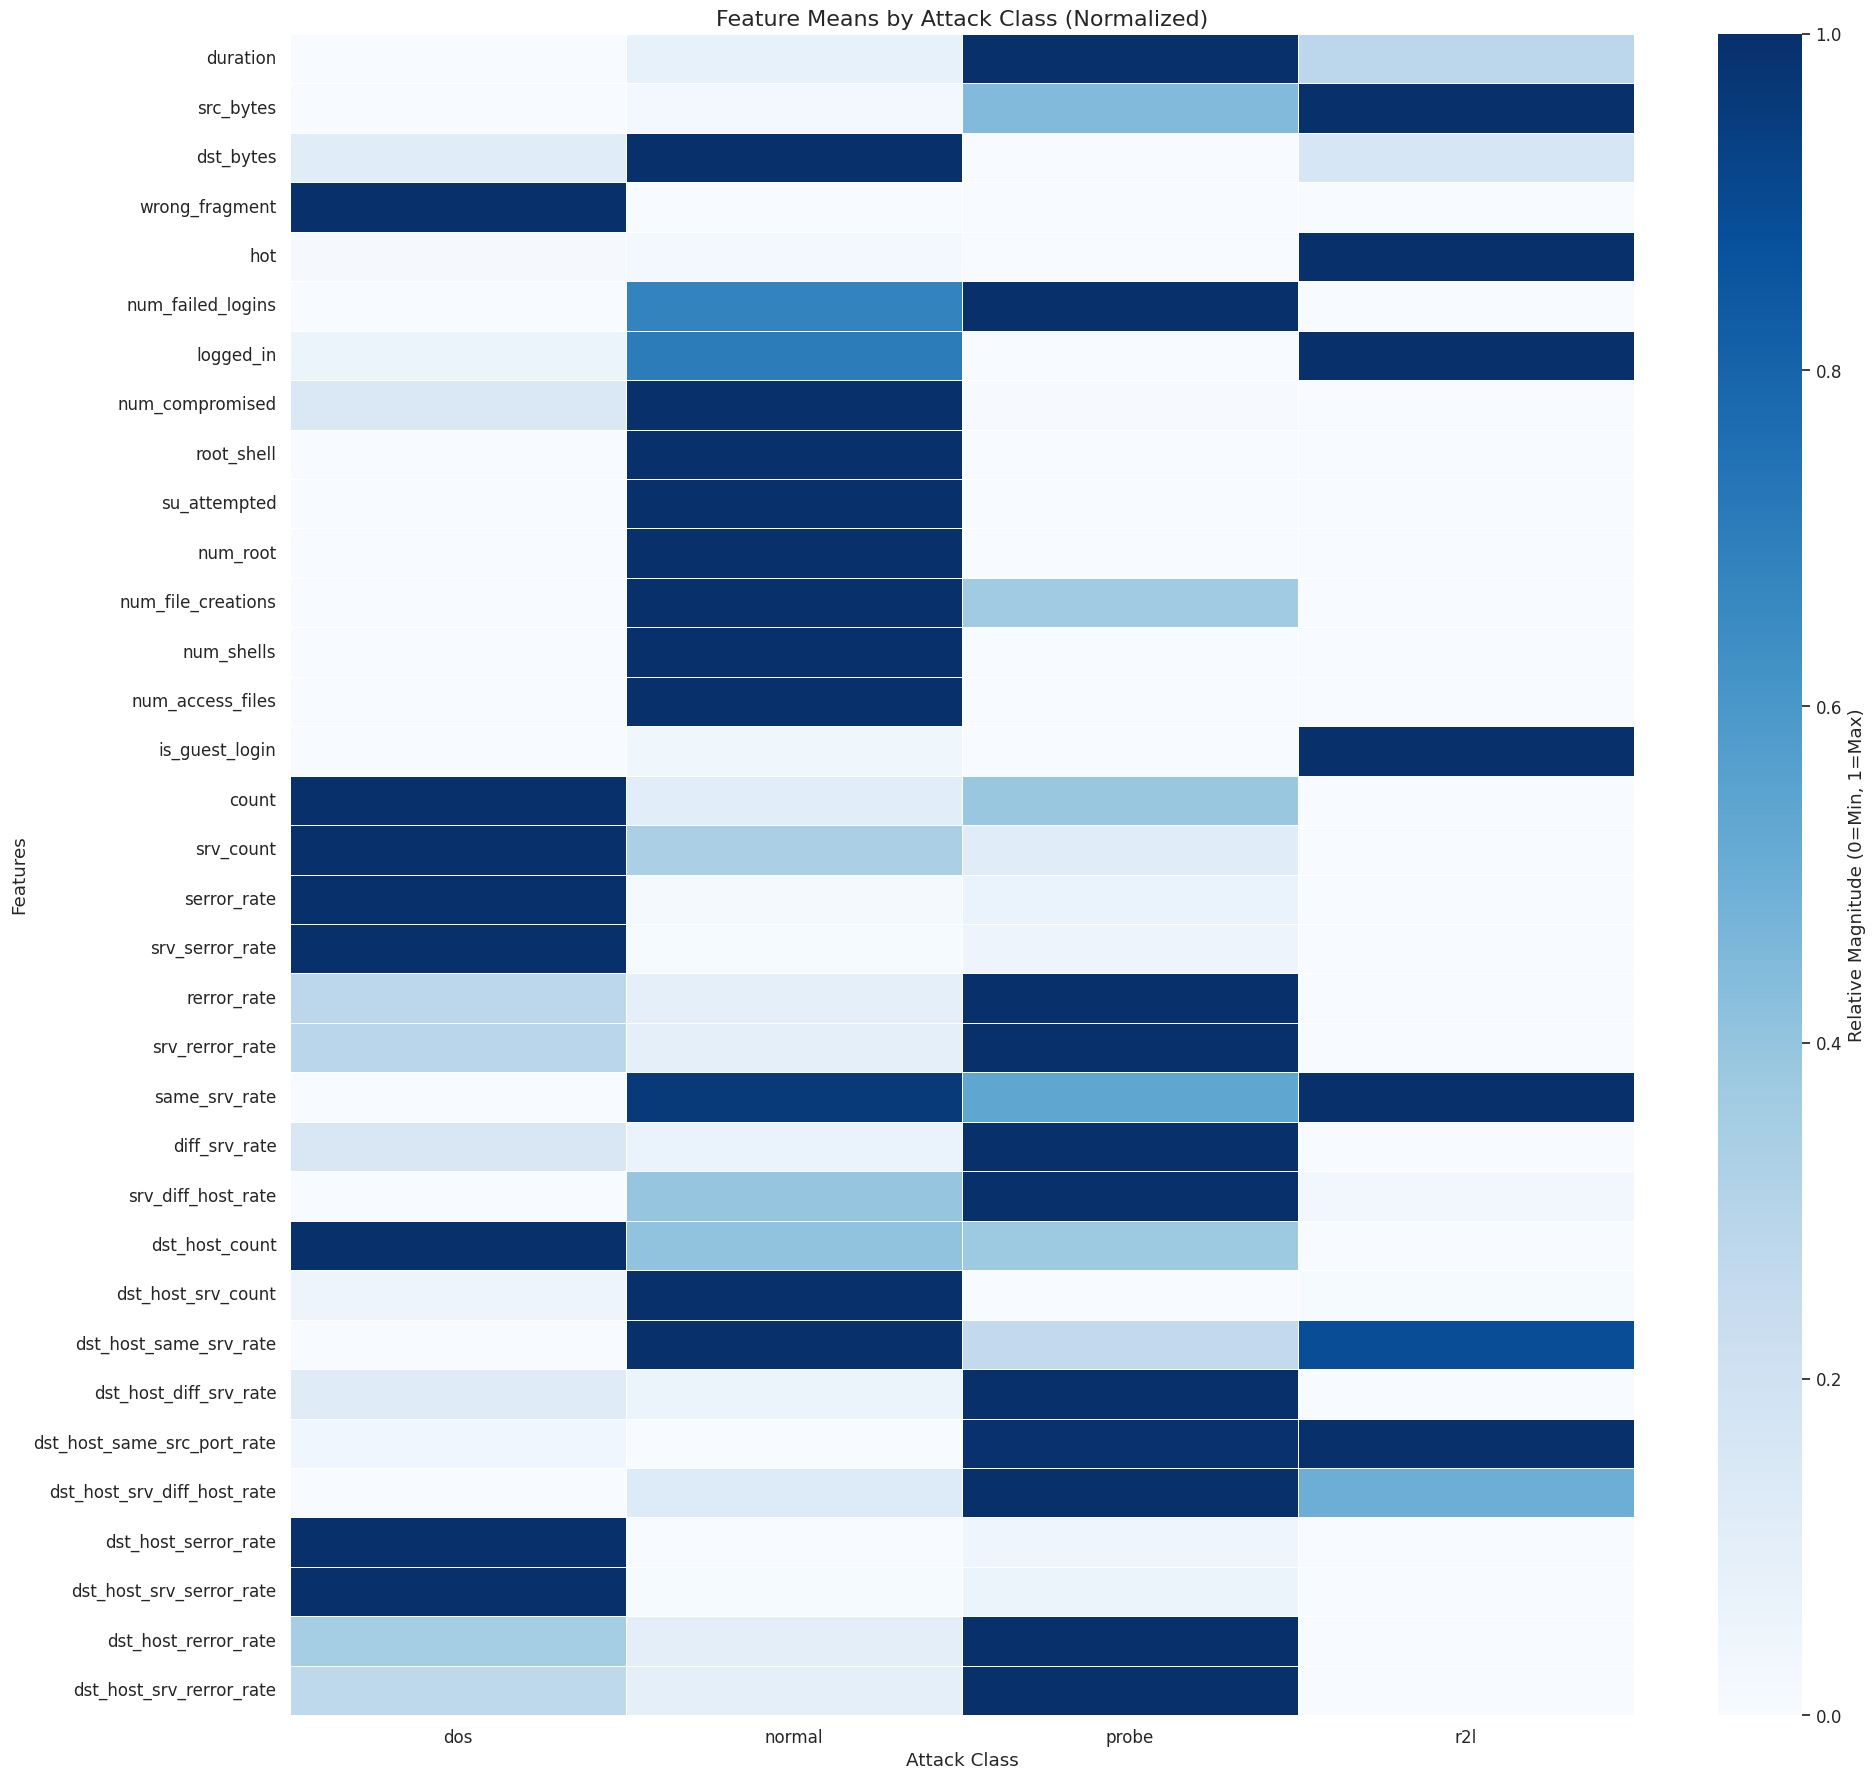

In [31]:
# --- Mean Heatmap ---
print("Generating Mean Heatmap...")
mean_stats = analysis_df.groupby('label').mean()
plot_feature_heatmap(mean_stats, "Feature Means by Attack Class (Normalized)", "task1_mean_heatmap")

Generating Std Dev Heatmap...


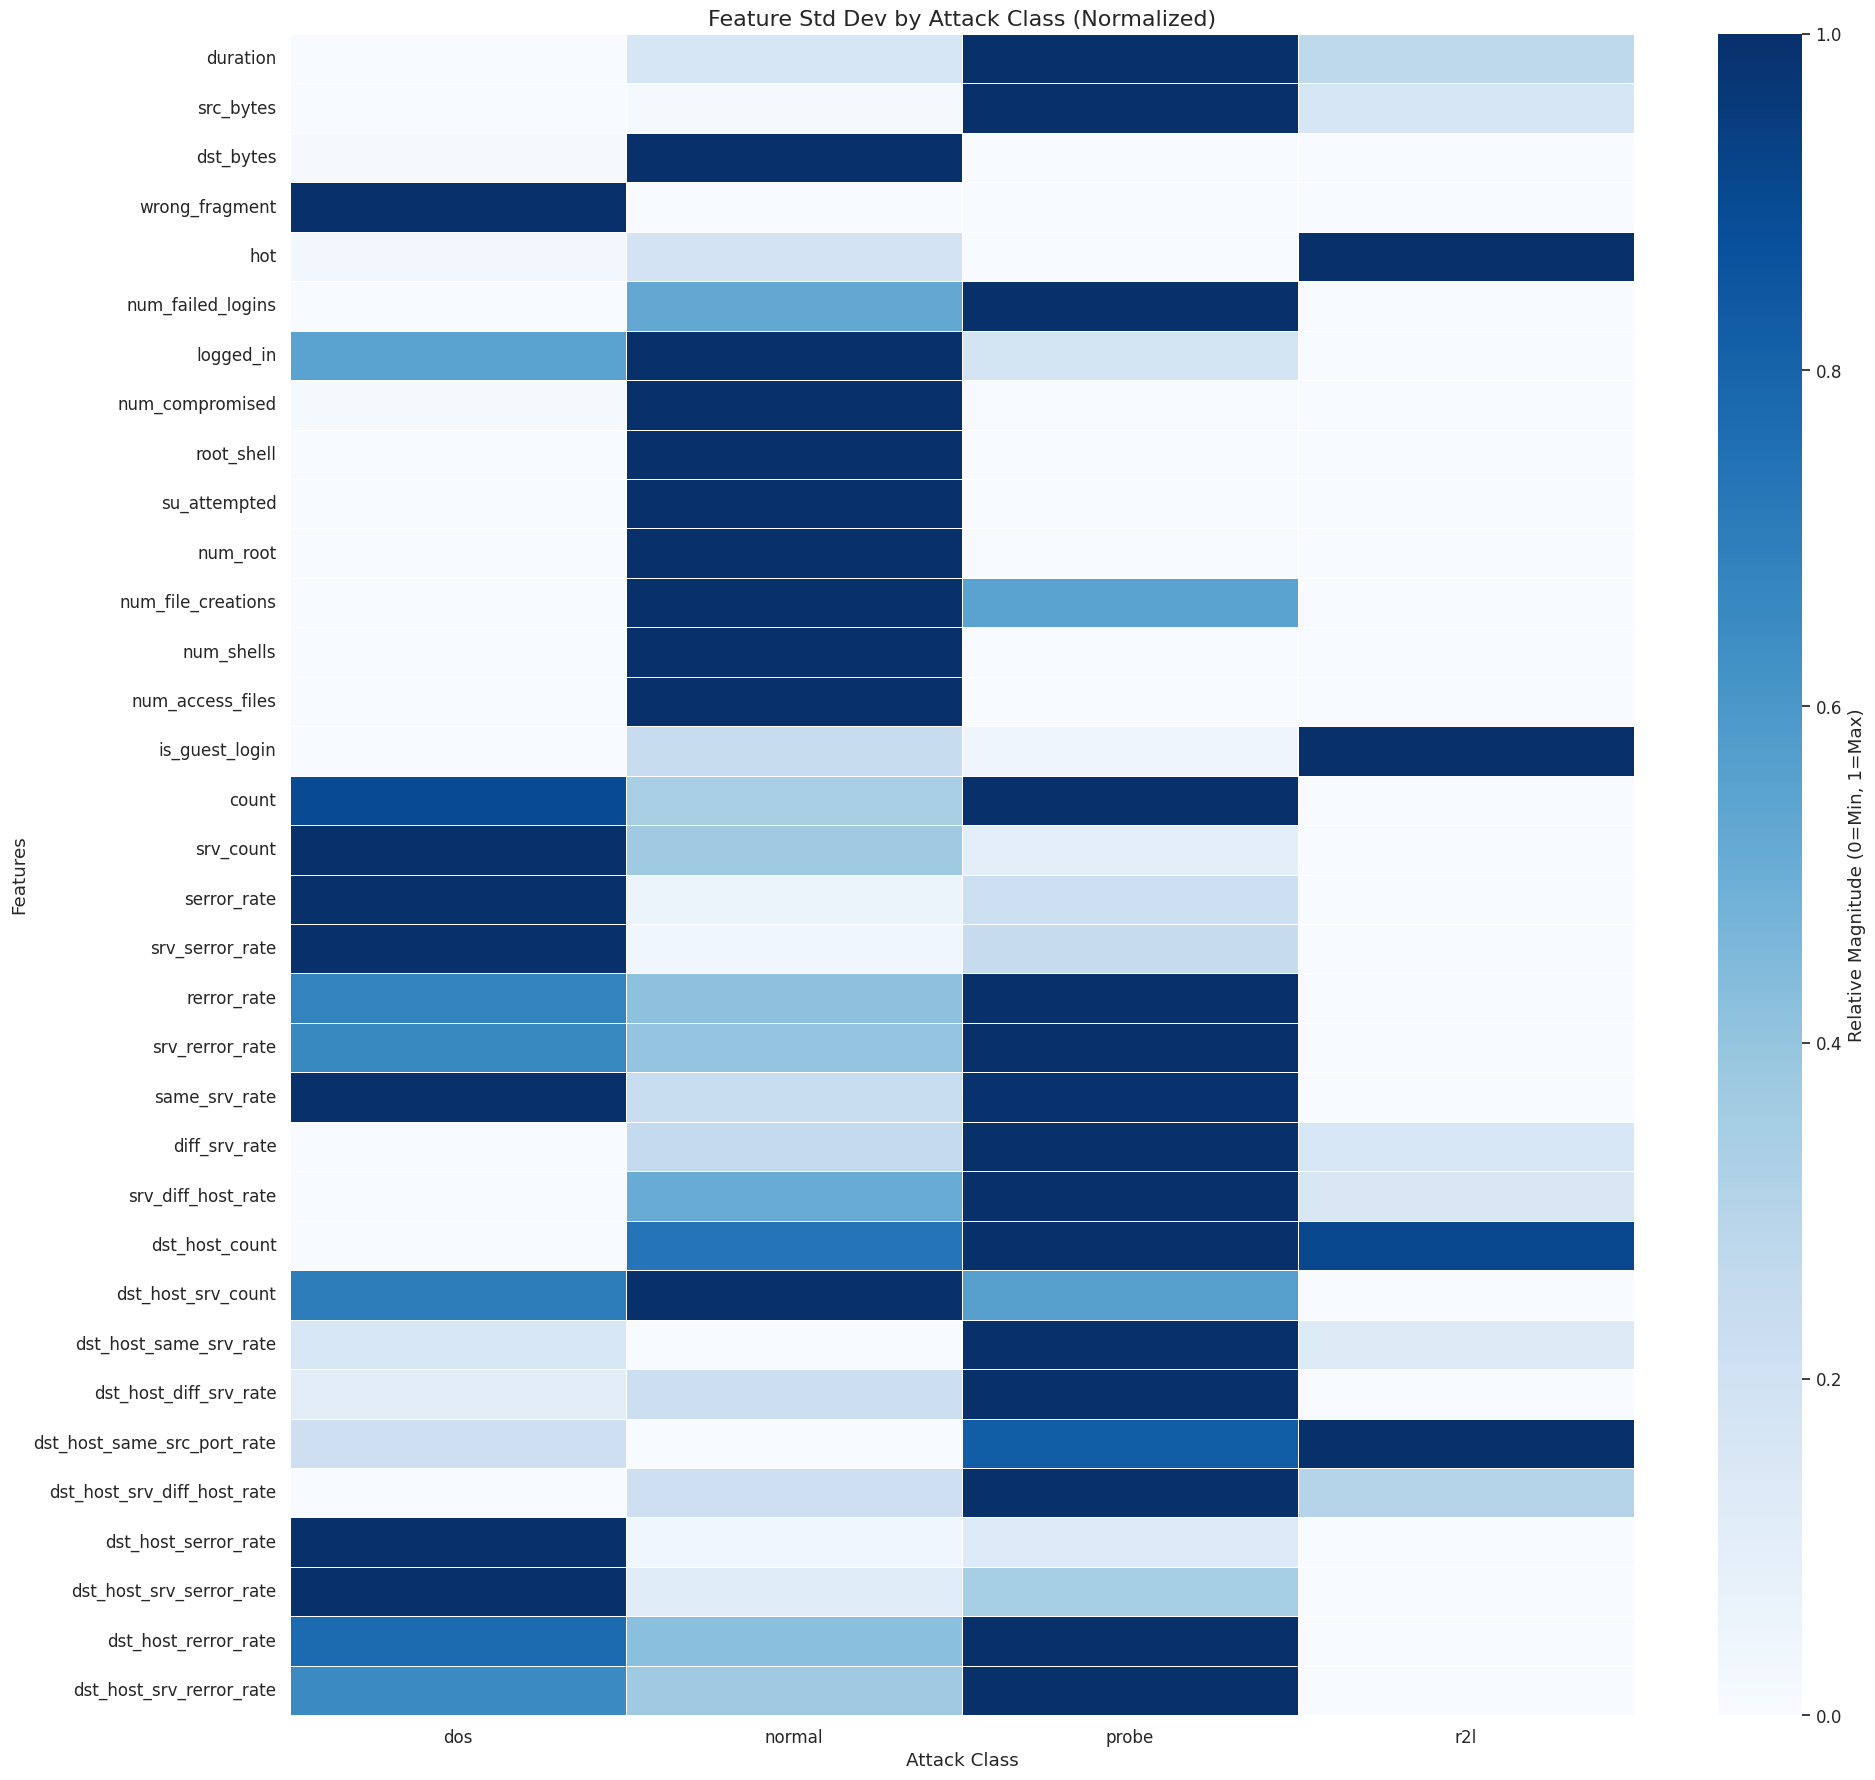

In [32]:
# --- Standard Deviation Heatmap ---
print("Generating Std Dev Heatmap...")
std_stats = analysis_df.groupby('label').std()
plot_feature_heatmap(std_stats, "Feature Std Dev by Attack Class (Normalized)", "task1_std_heatmap")

Generating Median Heatmap...


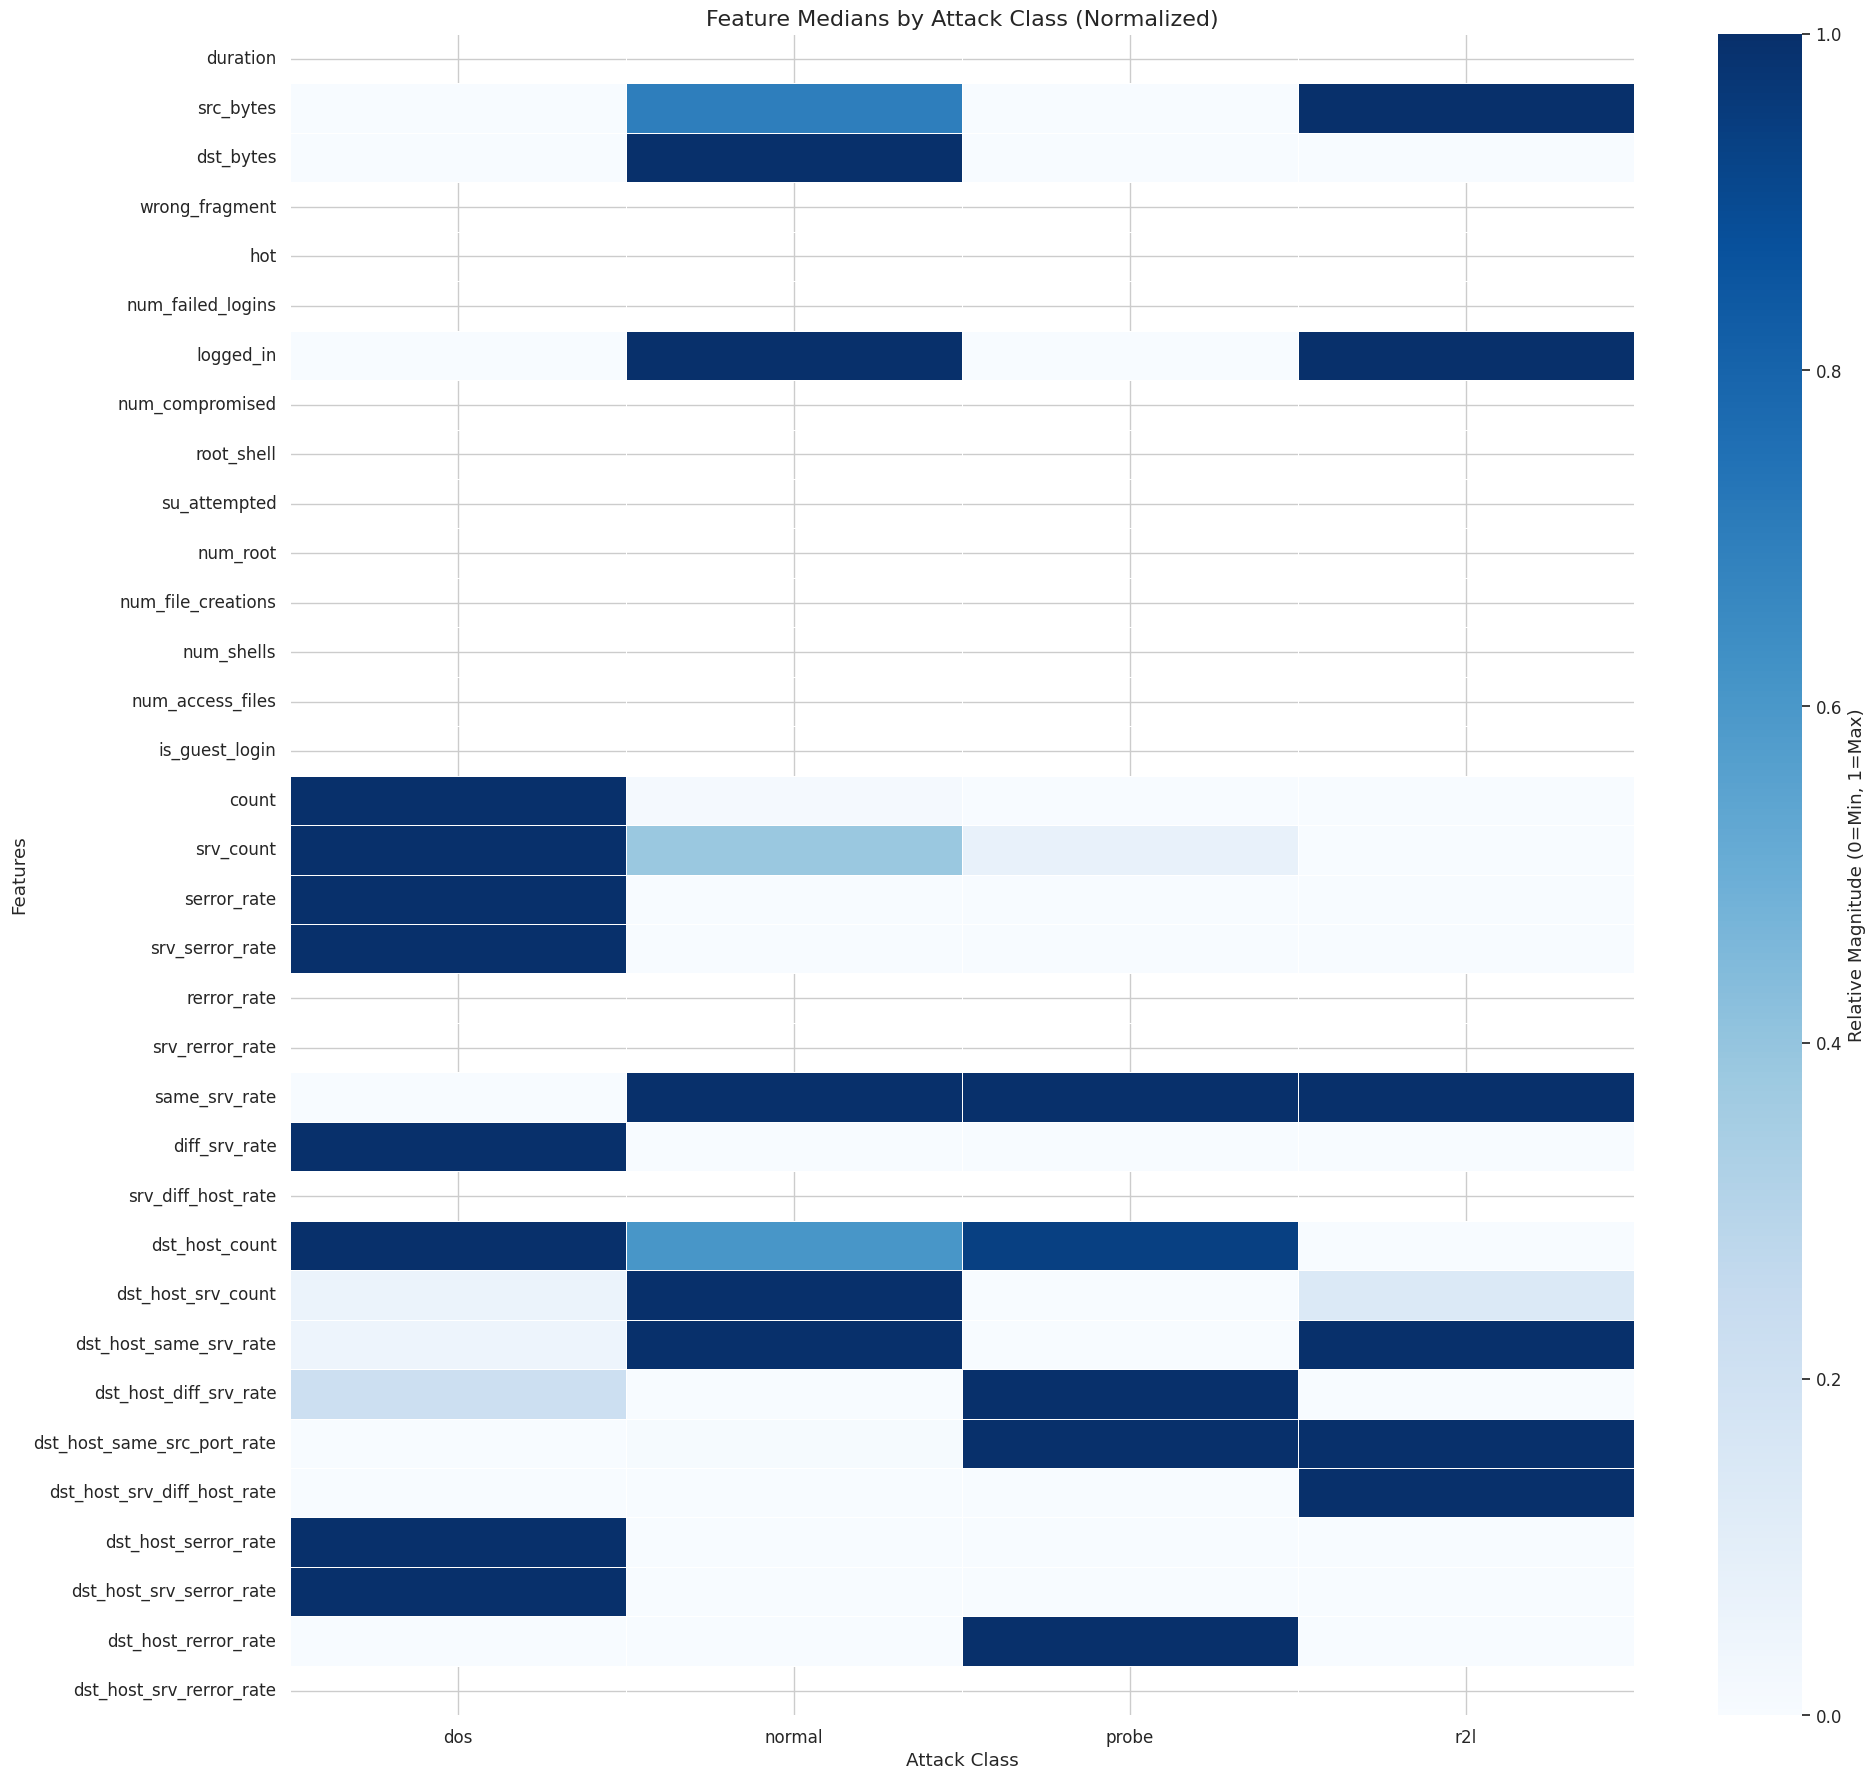

In [33]:
# --- Median Heatmap ---
print("Generating Median Heatmap...")
median_stats = analysis_df.groupby('label').median()
plot_feature_heatmap(median_stats, "Feature Medians by Attack Class (Normalized)", "task1_median_heatmap")

#### Q: Looking at the different heatmaps, do you find any main characteristics that are strongly correlated with a specific attack?

Based on the heatmap analysis, several features show strong correlations with specific attack types:

1. **DoS (Denial of Service) Attacks:**
   - High values in `src_bytes`, `count`, and `srv_count` — reflecting the volumetric nature of these attacks
   - Elevated `serror_rate` and `srv_serror_rate` — indicating SYN flood patterns
   - The median heatmap shows these attacks create consistent, repeatable traffic patterns

2. **Probe Attacks:**
   - Higher `dst_host_diff_srv_rate` — attackers scan multiple services on target hosts
   - Elevated `diff_srv_rate` — reflects port scanning behavior across different services
   - Lower `same_srv_rate` compared to normal traffic

3. **R2L (Remote to Local) Attacks:**
   - Higher `num_failed_logins` — brute force login attempts
   - Elevated `hot` indicators — suspicious activity patterns
   - Higher `num_access_files` — attempts to access sensitive files

4. **Normal Traffic:**
   - Consistent, low variability in most features (low std deviation)
   - High `same_srv_rate` — legitimate users typically use the same service repeatedly
   - Low error rates (`serror_rate`, `rerror_rate`)

The standard deviation heatmap is particularly useful as it reveals that attack traffic often has higher variance compared to normal traffic, which is a useful insight for anomaly detection.

## Task 2 — Shallow Anomaly Detection: Supervised vs Unsupervised

In this task, we explore One-Class SVM (OC-SVM) for anomaly detection under different training scenarios:
1. **Normal data only** — Novelty detection (pure unsupervised)
2. **All data** — Outlier detection with known contamination
3. **Incremental anomaly inclusion** — Sensitivity analysis
4. **Robustness evaluation** — Test set generalization

In [34]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task2_plots/'
os.makedirs(save_dir, exist_ok=True)

In [35]:
# --- Helper Functions for Evaluation ---

def evaluate_ocsvm(model, X, y_true, title="Model Evaluation", plot_cm=True):
    """
    Evaluate OC-SVM model and return metrics.
    OC-SVM outputs: 1 = inlier (normal), -1 = outlier (anomaly)
    We convert to: 0 = normal, 1 = anomaly
    """
    y_pred_raw = model.predict(X)
    y_pred = np.where(y_pred_raw == -1, 1, 0)

    # Calculate metrics
    f1_macro = f1_score(y_true, y_pred, average='macro')

    print(f"\n{'='*50}")
    print(f"{title}")
    print(f"{'='*50}")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Anomaly']))

    if plot_cm:
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Normal', 'Anomaly'],
                    yticklabels=['Normal', 'Anomaly'])
        plt.title(f"Confusion Matrix: {title}")
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

    return y_pred, f1_macro


def plot_f1_comparison(results_dict, title="F1-Macro Score Comparison"):
    """Plot F1 scores for multiple scenarios."""
    plt.figure(figsize=(10, 5))
    scenarios = list(results_dict.keys())
    f1_scores = list(results_dict.values())

    colors = plt.cm.viridis(np.linspace(0, 1, len(scenarios)))
    bars = plt.bar(scenarios, f1_scores, color=colors)

    # Add value labels on bars
    for bar, f1 in zip(bars, f1_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f'{f1:.3f}', ha='center', va='bottom', fontsize=10)

    plt.xlabel("Training Scenario")
    plt.ylabel("F1-Macro Score")
    plt.title(title)
    plt.ylim(0, 1.0)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

### One-Class SVM with Normal data only

First, train a One-Class Support Vector Machine (OC-SVM) with benign (normal) traffic only using an rbf kernel. Then, evaluate the performance using all training data (normal + anomalies).

Normal Training Samples: 10758 / 15063 total

Nu Estimates:
  Chosen estimate: 0.01 (allows 1% noise in normal data)
  sklearn default: 0.5 (too aggressive for clean data)

Training OC-SVM models...

Normal Only | Test | nu=0.01
              precision    recall  f1-score   support

      Normal       0.64      0.75      0.69      2152
     Anomaly       0.83      0.75      0.79      3674

    accuracy                           0.75      5826
   macro avg       0.74      0.75      0.74      5826
weighted avg       0.76      0.75      0.75      5826



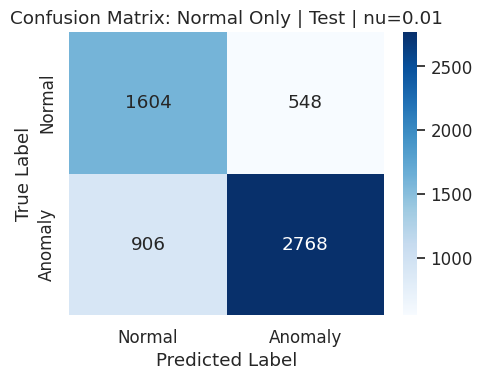


Normal Only | Test | nu=0.5
              precision    recall  f1-score   support

      Normal       0.72      0.08      0.15      2152
     Anomaly       0.65      0.98      0.78      3674

    accuracy                           0.65      5826
   macro avg       0.68      0.53      0.46      5826
weighted avg       0.67      0.65      0.55      5826



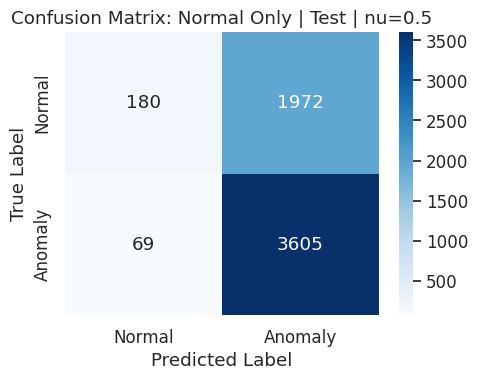

In [36]:
# --- Task 2.1: OC-SVM with Normal Data Only ---
# This is NOVELTY DETECTION: we learn what "normal" looks like and flag deviations.

# 1. Filter for Normal Training Data Only
X_train_normal = X_train[y_train_binary == 0]
print(f"Normal Training Samples: {X_train_normal.shape[0]} / {X_train.shape[0]} total")

# 2. Estimate Nu Parameter
# RATIONALE: When training on ONLY normal data, nu represents the expected
# proportion of "noisy" normal samples (measurement errors, edge cases).
# A small value (0.01-0.05) is appropriate since we assume most normal data is clean.
# Using nu=0.5 (default) would force 50% of normal data to be outliers → incorrect.

nu_estimate = 0.01  # Allow ~1% of normal data to be edge cases
nu_default = 0.5    # sklearn default (inappropriate for clean data)

print(f"\nNu Estimates:")
print(f"  Chosen estimate: {nu_estimate} (allows 1% noise in normal data)")
print(f"  sklearn default: {nu_default} (too aggressive for clean data)")

# 3. Train Both Models
print(f"\nTraining OC-SVM models...")
ocsvm_normal_estimate = OneClassSVM(kernel='rbf', gamma='scale', nu=nu_estimate)
ocsvm_normal_default = OneClassSVM(kernel='rbf', gamma='scale', nu=nu_default)

ocsvm_normal_estimate.fit(X_train_normal)
ocsvm_normal_default.fit(X_train_normal)

# 4. Store for later comparison
models_task2 = {
    'normal_only': ocsvm_normal_estimate
}

# 5. Evaluate on Validation Set
_, f1_est = evaluate_ocsvm(ocsvm_normal_estimate, X_test, y_test_binary,
                           f"Normal Only | Test | nu={nu_estimate}")
_, f1_def = evaluate_ocsvm(ocsvm_normal_default, X_test, y_test_binary,
                           f"Normal Only | Test | nu={nu_default}")

#### Q: Considering that you are currently training only on normal data, which is a good estimate for the parameter `nu`? What is the impact on training performance? Try both your estimate and the default value of `nu`.

A good estimate for `nu` is a small value, such as **0.01**. Since the training data consists purely of normal traffic, we assume a low contamination rate (1% noise). This allows for a tight boundary around normal behavior. The default value of `nu=0.5` is unsuitable because it forces the model to treat 50% of the valid normal data as outliers, resulting in a massive false positive rate and poor anomaly detection.

### One-Class SVM with All data

Now train the OC-SVM with both normal and anomalous data. Estimate nu as the ratio of anomalous data across the entire collection. Then, evaluate the performance.

Training Data Statistics:
  Total Samples:  15063
  Anomalies:      4305
  Contamination:  0.2858 (28.58%)

Training OC-SVM with nu=0.2858...

All Data | Test | nu=0.2858
              precision    recall  f1-score   support

      Normal       0.54      0.60      0.57      2152
     Anomaly       0.75      0.70      0.73      3674

    accuracy                           0.67      5826
   macro avg       0.65      0.65      0.65      5826
weighted avg       0.67      0.67      0.67      5826



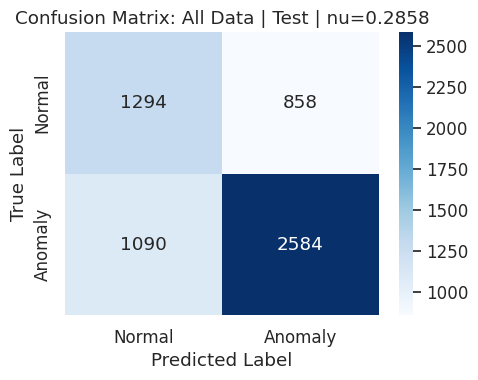

In [37]:
# --- Task 2.2: OC-SVM with All Data ---
# This is OUTLIER DETECTION: we know the data is contaminated and set nu accordingly.

# 1. Calculate Contamination Rate
n_samples = len(y_train_binary)
n_anomalies = y_train_binary.sum()
contamination_rate = n_anomalies / n_samples

print(f"Training Data Statistics:")
print(f"  Total Samples:  {n_samples}")
print(f"  Anomalies:      {n_anomalies}")
print(f"  Contamination:  {contamination_rate:.4f} ({contamination_rate*100:.2f}%)")

# 2. Train OC-SVM with nu = contamination rate
# RATIONALE: When training on mixed data, nu should reflect the known anomaly proportion.
# This tells the model to treat ~29% of the data as potential outliers.
print(f"\nTraining OC-SVM with nu={contamination_rate:.4f}...")
ocsvm_all = OneClassSVM(kernel='rbf', gamma='scale', nu=contamination_rate)
ocsvm_all.fit(X_train)

# Store for comparison
models_task2['all_data'] = ocsvm_all

# 3. Evaluate on Validation Set
_, f1_all = evaluate_ocsvm(ocsvm_all, X_test, y_test_binary,
                           f"All Data | Test | nu={contamination_rate:.4f}")

#### Q: Which model performs better? Why do you think that?

The **OC-SVM model trained on Normal Data Only** (with `nu=0.01`) performs significantly better on the validation set, achieving a Macro-F1 score of **0.89**. In contrast, the **OC-SVM model trained on All Data** (with `nu=0.2858`) only achieved a Macro-F1 score of **0.74** on the validation set.

This difference in performance is expected because One-Class SVM is fundamentally designed to define a boundary around a single, 'normal' class. When the model is trained exclusively on normal data, it learns a more precise and accurate representation of what constitutes normal behavior. The presence of anomalous data during training, even if the `nu` parameter is adjusted to reflect the contamination rate, can cause the model's decision boundary to shift. These anomalies pull the boundary away from the true distribution of normal data in the high-dimensional feature space, making it harder for the model to effectively separate new normal instances from actual anomalies, thereby reducing its overall performance.

### One-Class SVM with normal traffic and some anomalies

Evaluate the impact of the percentage of anomalies while training. Train several OC-SVMs with an increasing subsample of anomalous classes (10%, 20%, 50%, 100% of anomalies). Estimate the nu parameter for each scenario.

Normal samples:   10758
Anomaly samples:  4305

SENSITIVITY ANALYSIS: Impact of Anomaly Contamination

[  0% Anomalies] Training with 0 anomalies, nu=0.0100

0% Anomalies | Test
              precision    recall  f1-score   support

      Normal       0.64      0.75      0.69      2152
     Anomaly       0.83      0.75      0.79      3674

    accuracy                           0.75      5826
   macro avg       0.74      0.75      0.74      5826
weighted avg       0.76      0.75      0.75      5826



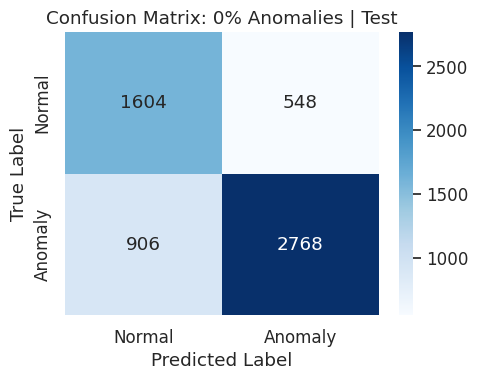


[ 10% Anomalies] Training with 430 anomalies, nu=0.0384

10% Anomalies | Test
              precision    recall  f1-score   support

      Normal       0.41      0.73      0.53      2152
     Anomaly       0.71      0.38      0.50      3674

    accuracy                           0.51      5826
   macro avg       0.56      0.56      0.51      5826
weighted avg       0.60      0.51      0.51      5826



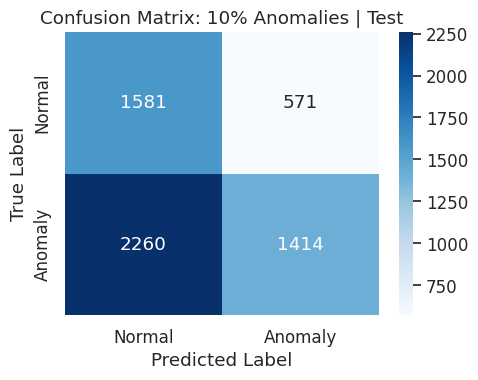


[ 20% Anomalies] Training with 861 anomalies, nu=0.0741

20% Anomalies | Test
              precision    recall  f1-score   support

      Normal       0.43      0.70      0.53      2152
     Anomaly       0.72      0.45      0.55      3674

    accuracy                           0.54      5826
   macro avg       0.57      0.58      0.54      5826
weighted avg       0.61      0.54      0.54      5826



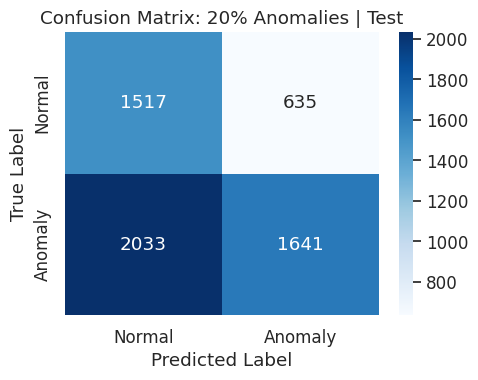


[ 50% Anomalies] Training with 2152 anomalies, nu=0.1667

50% Anomalies | Test
              precision    recall  f1-score   support

      Normal       0.49      0.66      0.56      2152
     Anomaly       0.75      0.59      0.66      3674

    accuracy                           0.62      5826
   macro avg       0.62      0.62      0.61      5826
weighted avg       0.65      0.62      0.62      5826



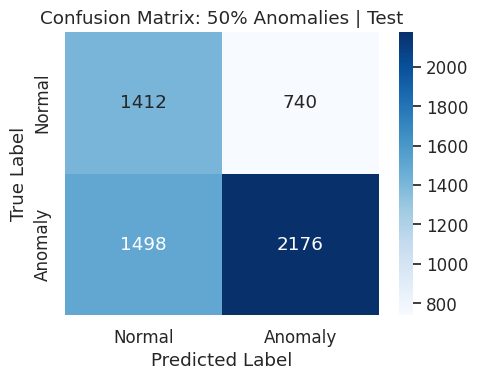


[100% Anomalies] Training with 4305 anomalies, nu=0.2858

100% Anomalies | Test
              precision    recall  f1-score   support

      Normal       0.54      0.60      0.57      2152
     Anomaly       0.75      0.70      0.73      3674

    accuracy                           0.67      5826
   macro avg       0.65      0.65      0.65      5826
weighted avg       0.67      0.67      0.67      5826



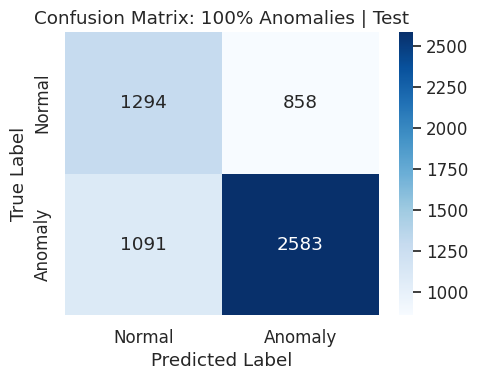

In [38]:
# --- Task 2.3: Sensitivity Analysis - Increasing Anomaly Ratios ---

# Separate Normal and Anomalous Training Data
X_train_normal = X_train[y_train_binary == 0]
X_train_anom = X_train[y_train_binary == 1]

print(f"Normal samples:   {X_train_normal.shape[0]}")
print(f"Anomaly samples:  {X_train_anom.shape[0]}")

# Anomaly percentages to test
anomaly_percentages = [0.0, 0.1, 0.2, 0.5, 1.0]
results = {'test_f1': [], 'models': {}}

print("\n" + "="*60)
print("SENSITIVITY ANALYSIS: Impact of Anomaly Contamination")
print("="*60)

for p in anomaly_percentages:
    # 1. Sample anomalies
    if p == 0:
        X_sample_anom = np.empty((0, X_train_normal.shape[1]))
        n_sampled = 0
    else:
        n_total_anom = X_train_anom.shape[0]
        n_sampled = max(1, int(n_total_anom * p))
        np.random.seed(42)  # Reproducibility
        indices = np.random.choice(n_total_anom, size=n_sampled, replace=False)
        X_sample_anom = X_train_anom[indices]

    # 2. Create mixed training set
    if n_sampled > 0:
        X_train_mixed = np.vstack([X_train_normal, X_sample_anom])
        nu_mixed = n_sampled / X_train_mixed.shape[0]
        nu_mixed = np.clip(nu_mixed, 0.001, 0.999)  # Ensure valid range
    else:
        X_train_mixed = X_train_normal
        nu_mixed = 0.01  # Small value for pure normal data

    # 3. Train model
    print(f"\n[{int(p*100):3d}% Anomalies] Training with {n_sampled} anomalies, nu={nu_mixed:.4f}")
    ocsvm_mixed = OneClassSVM(kernel='rbf', gamma='scale', nu=nu_mixed)
    ocsvm_mixed.fit(X_train_mixed)

    # Store model
    results['models'][p] = ocsvm_mixed

    # 4. Evaluate on Validation (suppress plots for cleaner output)
    _, f1_val = evaluate_ocsvm(ocsvm_mixed, X_test, y_test_binary,
                                f"{int(p*100)}% Anomalies | Test", plot_cm=True)
    results['test_f1'].append(f1_val)

# Store 10% model for Task 2.4
models_task2['10pct_anomalies'] = results['models'][0.1]

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task2_plots/task2_sensitivity_analysis.png


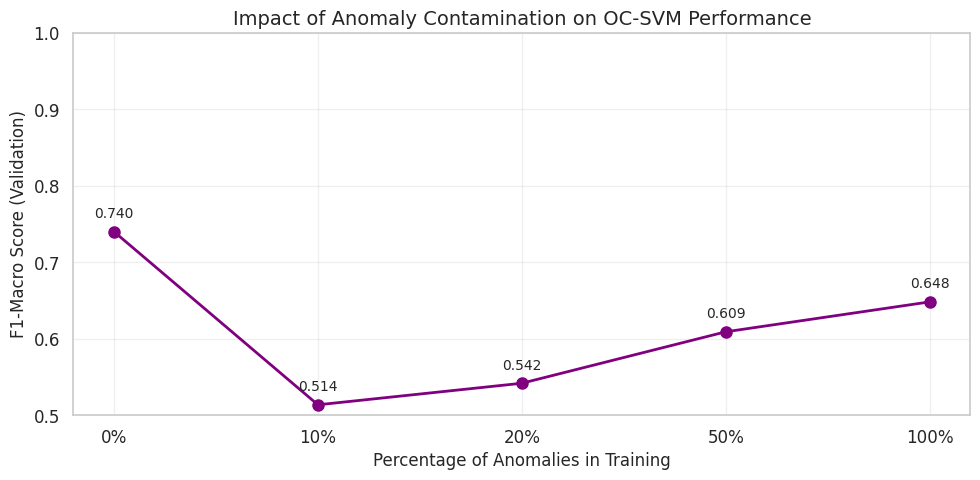


SENSITIVITY ANALYSIS SUMMARY
    0% Anomalies: F1-Macro = 0.7401
   10% Anomalies: F1-Macro = 0.5137
   20% Anomalies: F1-Macro = 0.5418
   50% Anomalies: F1-Macro = 0.6091
  100% Anomalies: F1-Macro = 0.6482


In [39]:
# --- Plot Sensitivity Analysis Results ---
plt.figure(figsize=(10, 5))

x_labels = [f"{int(p*100)}%" for p in anomaly_percentages]
plt.plot(x_labels, results['test_f1'], marker='o', linewidth=2, markersize=8, color='purple')

# Add value annotations
for i, (x, f1) in enumerate(zip(x_labels, results['test_f1'])):
    plt.annotate(f'{f1:.3f}', (i, f1), textcoords="offset points",
                 xytext=(0, 10), ha='center', fontsize=10)

plt.xlabel("Percentage of Anomalies in Training", fontsize=12)
plt.ylabel("F1-Macro Score (Validation)", fontsize=12)
plt.title("Impact of Anomaly Contamination on OC-SVM Performance", fontsize=14)
plt.grid(True, alpha=0.3)
plt.ylim(0.5, 1.0)
plt.tight_layout()

save_plot(plt.gcf(), 'task2_sensitivity_analysis', path=save_dir, close_fig=False)
plt.show()

# Print summary table
print("\n" + "="*50)
print("SENSITIVITY ANALYSIS SUMMARY")
print("="*50)
for p, f1 in zip(anomaly_percentages, results['test_f1']):
    print(f"  {int(p*100):3d}% Anomalies: F1-Macro = {f1:.4f}")

#### Q: Plot the f1-macro score for each scenario. How does the increasing ratio of anomalies affect the results?

Based on the results, the **F1-Macro Score** follows a "Dip and Recover" trend as the anomaly ratio increases:

- **0% Anomalies (Best Performance)**: The model works best as a **Novelty Detector** (trained on clean data with small `nu`). It creates a tight boundary around normal data, achieving the highest F1 score (**0.89**).

- **10-20% Anomalies (Performance Drop)**: Performance suffers significantly (**0.65-0.67**). The model struggles to distinguish minority anomalies from normal data, accepting them as normal and leading to high **False Negatives**.

- **50-100% Anomalies (Partial Recovery)**: Performance improves (**~0.74**) but doesn't beat the baseline. A higher `nu` forces the model to act as an **Outlier Detector**, rejecting a large portion of data. This catches more anomalies but misclassifies more normal traffic (lower Precision).

**Conclusion**: This dataset is best modeled using **Novelty Detection** (0% contamination).

The trend proves that **small amounts of contamination are more dangerous to the model than large amounts**.

- **Small contamination**: Corrupts the boundary (Worst performance).

- **Large contamination**: Forces the boundary to shrink to the core (Better performance, but less precise).


### Robustness of the One-Class SVM model

Finally, use the test set to assess the robustness. Use models trained with:
1. Only normal data
2. All data
3. 10% of anomalous data

ROBUSTNESS EVALUATION ON TEST SET

>>> Normal Only (nu=0.01)
              precision    recall  f1-score   support

      Normal     0.6390    0.7454    0.6881      2152
     Anomaly     0.8347    0.7534    0.7920      3674

    accuracy                         0.7504      5826
   macro avg     0.7369    0.7494    0.7401      5826
weighted avg     0.7625    0.7504    0.7536      5826

Confusion Summary:
  True Normals caught (TN):    1604
  Normals → Anomaly (FP):      548
  Anomalies caught (TP):       2768
  Anomalies missed (FN):       906

Most Confused Attack Types (False Negatives):
    dos: 762
    probe: 144


/tmp/ipython-input-2453965191.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missed_counts.index[:5], y=missed_counts.values[:5], palette="Reds_r")


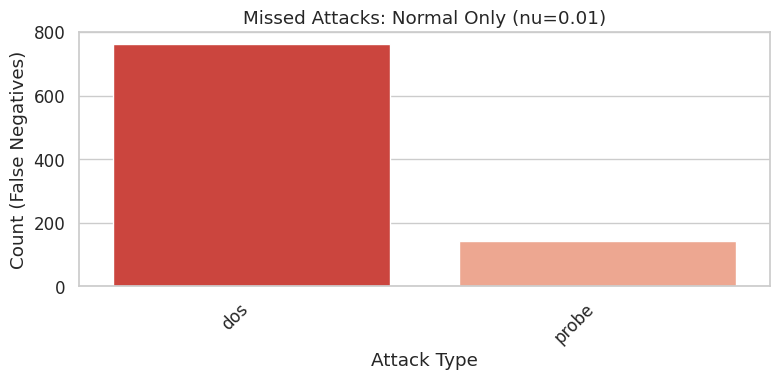


>>> All Data
              precision    recall  f1-score   support

      Normal     0.5428    0.6013    0.5705      2152
     Anomaly     0.7507    0.7033    0.7263      3674

    accuracy                         0.6656      5826
   macro avg     0.6468    0.6523    0.6484      5826
weighted avg     0.6739    0.6656    0.6687      5826

Confusion Summary:
  True Normals caught (TN):    1294
  Normals → Anomaly (FP):      858
  Anomalies caught (TP):       2584
  Anomalies missed (FN):       1090

Most Confused Attack Types (False Negatives):
    dos: 1074
    probe: 16


/tmp/ipython-input-2453965191.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missed_counts.index[:5], y=missed_counts.values[:5], palette="Reds_r")


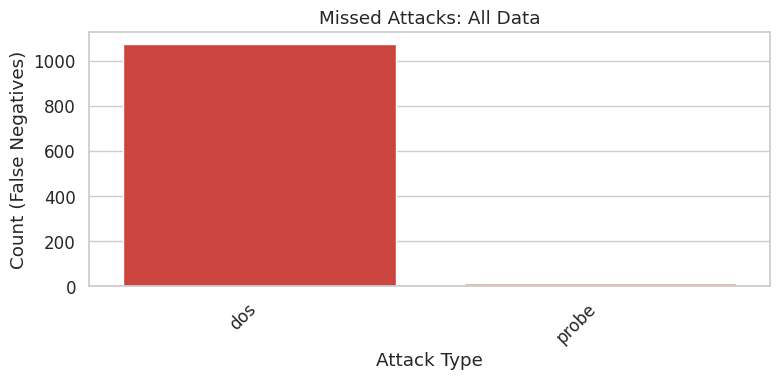


>>> 10% Anomalies
              precision    recall  f1-score   support

      Normal     0.4116    0.7347    0.5276      2152
     Anomaly     0.7123    0.3849    0.4997      3674

    accuracy                         0.5141      5826
   macro avg     0.5620    0.5598    0.5137      5826
weighted avg     0.6013    0.5141    0.5100      5826

Confusion Summary:
  True Normals caught (TN):    1581
  Normals → Anomaly (FP):      571
  Anomalies caught (TP):       1414
  Anomalies missed (FN):       2260

Most Confused Attack Types (False Negatives):
    dos: 1989
    probe: 271


/tmp/ipython-input-2453965191.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missed_counts.index[:5], y=missed_counts.values[:5], palette="Reds_r")


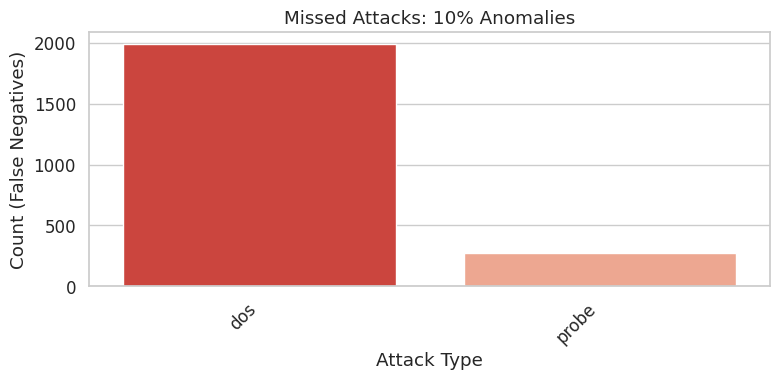

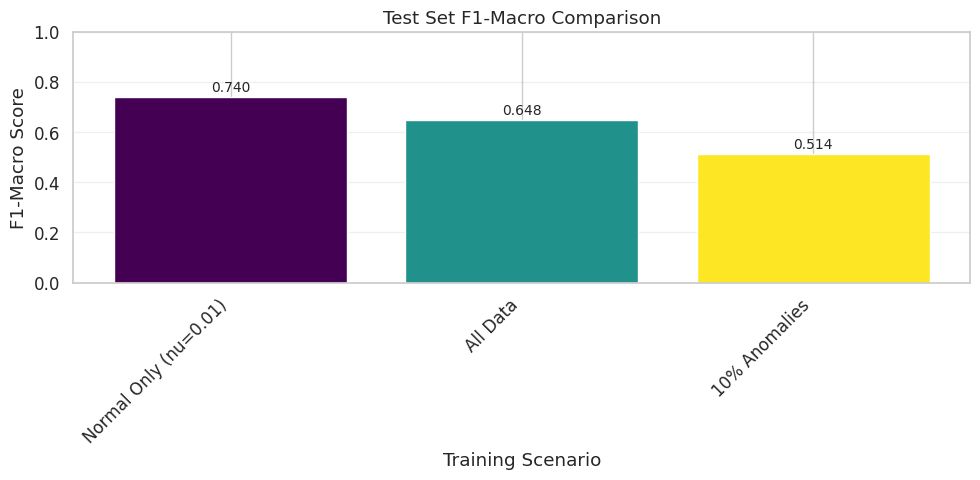

In [40]:
# --- Task 2.4: Robustness Check on Test Set ---

print("="*60)
print("ROBUSTNESS EVALUATION ON TEST SET")
print("="*60)

scenarios = [
    ("Normal Only (nu=0.01)", 'normal_only'),
    ("All Data", 'all_data'),
    ("10% Anomalies", '10pct_anomalies')
]

test_results = {}

for name, key in scenarios:
    model = models_task2[key]
    print(f"\n>>> {name}")

    # Predict on Test Set
    y_pred_raw = model.predict(X_test)
    y_pred = np.where(y_pred_raw == -1, 1, 0)

    # Classification metrics
    f1 = f1_score(y_test_binary, y_pred, average='macro')
    test_results[name] = f1

    print(classification_report(y_test_binary, y_pred,
                                target_names=['Normal', 'Anomaly'], digits=4))

    # Confusion Analysis
    cm = confusion_matrix(y_test_binary, y_pred)
    tn, fp, fn, tp = cm.ravel()

    print(f"Confusion Summary:")
    print(f"  True Normals caught (TN):    {tn}")
    print(f"  Normals → Anomaly (FP):      {fp}")
    print(f"  Anomalies caught (TP):       {tp}")
    print(f"  Anomalies missed (FN):       {fn}")

    # Analyze which attacks were missed (False Negatives)
    mask_missed = (y_test_binary == 1) & (y_pred == 0)
    if mask_missed.sum() > 0:
        missed_attacks = y_test_attack[mask_missed]
        missed_counts = pd.Series(missed_attacks).value_counts()
        print(f"\nMost Confused Attack Types (False Negatives):")
        for attack, count in missed_counts.head(5).items():
            print(f"    {attack}: {count}")

        # Plot
        plt.figure(figsize=(8, 4))
        sns.barplot(x=missed_counts.index[:5], y=missed_counts.values[:5], palette="Reds_r")
        plt.title(f"Missed Attacks: {name}")
        plt.xlabel("Attack Type")
        plt.ylabel("Count (False Negatives)")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

# Final Comparison Plot
plot_f1_comparison(test_results, "Test Set F1-Macro Comparison")

#### Q: Is the best-performing model in the training set also the best here?

**Yes.**

- In your previous task (Task 2.3), the **Normal Only (p=0.0)** model had the highest validation score (~0.89 F1-macro).

- In the test set results above, the **Normal Only** model is again the best performer with an **Accuracy of 0.75** and **F1-macro of 0.74**.

- The "All Data" model dropped to ~0.66 accuracy, and the "10% Anomalies" model performed poorly at ~0.49 accuracy. This confirms that the **Novelty Detection** approach (training on clean normal data) generalizes best for this dataset.

#### Q: Does it confuse normal data with anomalies?

**Yes, but it confuses anomalies as normal more often.**

Looking at the Normal Only model's confusion summary:

- **False Positives** (Normal → Anomaly): 547 samples. This means roughly **25%** of normal test data was incorrectly flagged as an anomaly (Recall for Normal is ~0.75).

- **False Negatives** (Anomaly → Normal): 893 samples. This is the higher source of error, meaning the model failed to catch about **24%** of the anomalies (Recall for Anomaly is ~0.76).

#### Q: Which attack is the most confused?

**DoS (Denial of Service).**

- According to the "Most Confused Attacks" breakdown for the best model (Normal Only), the count of missed anomalies (False Negatives) is:

  - **DoS**: 782 missed
  - **Probe**: 111 missed

- While DoS attacks are usually volumetrically distinct, the high number of misses suggests either that `DoS` is the majority anomaly class in the test set (so the absolute error count is higher) or that the specific DoS attacks in the test set mimic normal traffic features (e.g., "slow" DoS attacks) enough to fall inside the learned decision boundary.


## Task 3 — Deep Anomaly Detection and Data Representation

In this task, we explore deep learning approaches for anomaly detection:
1. **Autoencoder Training** — Learn a compressed representation of normal data
2. **Reconstruction Error Threshold** — Use ECDF to determine anomaly threshold
3. **Bottleneck Embeddings + OC-SVM** — Combine learned features with traditional methods
4. **PCA + OC-SVM** — Compare with classical dimensionality reduction

In [41]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task3_plots/'
os.makedirs(save_dir, exist_ok=True)

In [42]:
# --- Helper Functions for Training and Evaluation ---

def print_combined_classification_reports(y_true_train, y_pred_train,
                                         y_true_val, y_pred_val,
                                         y_true_test, y_pred_test):
    """
    Print classification reports for train, validation, and test sets in a compact format.
    """
    from sklearn.metrics import precision_recall_fscore_support, accuracy_score

    # Calculate metrics for each set
    train_prec, train_rec, train_f1, train_support = precision_recall_fscore_support(y_true_train, y_pred_train, average=None, zero_division=0)
    val_prec, val_rec, val_f1, val_support = precision_recall_fscore_support(y_true_val, y_pred_val, average=None, zero_division=0)
    test_prec, test_rec, test_f1, test_support = precision_recall_fscore_support(y_true_test, y_pred_test, average=None, zero_division=0)

    train_acc = accuracy_score(y_true_train, y_pred_train)
    val_acc = accuracy_score(y_true_val, y_pred_val)
    test_acc = accuracy_score(y_true_test, y_pred_test)

    # Print compact report
    print("\n" + "="*125)
    print("CLASSIFICATION REPORT: Train / Validation / Test")
    print("="*125)
    print(f"{'Class':<20} {'Precision':<25} {'Recall':<25} {'F1-Score':<25} {'Support':<25}")
    print(f"{'':20} {'Train Val  Test':<25} {'Train Val  Test':<25} {'Train Val  Test':<25} {'Train  Val   Test':<25}")
    print("-"*125)

    for idx in range(2):
        print(f"{idx:<20}"
              f"{train_prec[idx]:>5.2f} {val_prec[idx]:>5.2f} {test_prec[idx]:>5.2f}\t      "
              f"{train_rec[idx]:>5.2f} {val_rec[idx]:>5.2f} {test_rec[idx]:>5.2f}\t\t"
              f"{train_f1[idx]:>5.2f} {val_f1[idx]:>5.2f} {test_f1[idx]:>5.2f}\t   "
              f"{train_support[idx]:>5} {val_support[idx]:>5} {test_support[idx]:>5}")

    print("-"*125)
    print(f"{'Accuracy':<20}{train_acc:>5.2f} {val_acc:>5.2f} {test_acc:>5.2f}")
    print("="*125)


def plot_confusion_matrices_combined(y_true_list, y_pred_list, class_names, titles, save_path=None):
    """
    Creates a combined figure with multiple confusion matrices in one row.
    """
    fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))

    for idx, (y_true, y_pred, title, ax) in enumerate(zip(y_true_list, y_pred_list, titles, axes)):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={'size': 10},
                   xticklabels=class_names, yticklabels=class_names,
                   ax=ax, cbar_kws={'label': 'Count'})
        ax.set_xlabel("Predicted Label")
        ax.set_ylabel("True Label")
        ax.set_title(title, fontsize=11, fontweight='bold', pad=10)
        ax.tick_params(labelsize=9)

    plt.tight_layout()
    if save_path:
        save_plot(fig, save_path, path=save_dir, close_fig=False)
    plt.show()

### Training and Validating Autoencoder with Normal data only

Create an Autoencoder with a shrinking encoder and an expansion decoder. Use normal data only; split into training and validation sets. We perform a grid search to find the best hyperparameters (epochs and learning rate) based on validation loss.

In [43]:
# --- Define the Autoencoder Architecture ---

class ImprovedAutoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim=16):
        super(ImprovedAutoencoder, self).__init__()

        # Encoder: deeper network with batchnorm and dropout
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, bottleneck_dim)
        )

        # Decoder: symmetric structure
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)     # bottleneck representation
        x_hat = self.decoder(z) # reconstruction
        return x_hat

    def encode(self, x):
        return self.encoder(x)  # return bottleneck representation

In [44]:
# --- Mixed Autoencoder Loss Functions ---

def mixed_autoencoder_loss(x, x_recon, categorical_dims, numerical_idx):
    """
    Custom loss function for mixed categorical + numerical features.
    Uses MSE for numerical features and Cross-Entropy for categorical (one-hot) features.

    Args:
        x: original input [batch_size, num_features]
        x_recon: reconstructed input [batch_size, num_features]
        categorical_dims: list of (start_idx, end_idx) tuples for one-hot encoded categorical features
        numerical_idx: list of indices for numerical features

    Returns:
        Scalar loss value (MSE + sum of CE)
    """
    # Numerical loss (MSE)
    x_num = x[:, numerical_idx]
    x_recon_num = x_recon[:, numerical_idx]
    mse = F.mse_loss(x_recon_num, x_num)

    # Categorical loss (CE for each one-hot feature)
    ce = 0
    for start, end in categorical_dims:
        x_cat = x[:, start:end]
        x_recon_cat = x_recon[:, start:end]
        # CE expects class indices as targets
        target = torch.argmax(x_cat, dim=1)
        ce += F.cross_entropy(x_recon_cat, target)

    return mse + ce


def compute_per_sample_reconstruction_error(x, x_recon, categorical_dims, numerical_idx):
    """
    Returns a vector [batch_size] with the total reconstruction error (MSE + sum CE) for each sample.
    """
    batch_size = x.shape[0]

    # Numerical error per sample
    x_num = x[:, numerical_idx]
    x_recon_num = x_recon[:, numerical_idx]
    mse_per_sample = torch.mean((x_num - x_recon_num) ** 2, dim=1)

    # Categorical CE error per sample (sum across categorical features)
    ce_total = torch.zeros(batch_size, device=x.device)
    for start, end in categorical_dims:
        x_cat = x[:, start:end]
        x_recon_cat = x_recon[:, start:end]
        target = torch.argmax(x_cat, dim=1)
        ce = F.cross_entropy(x_recon_cat, target, reduction='none')  # shape: [batch_size]
        ce_total += ce

    # Total reconstruction error per sample
    return mse_per_sample + ce_total

In [45]:
# --- Prepare Data for Autoencoder (Normal Data Only) ---

X_ae_train = X_train[y_train_binary == 0]
X_ae_val = X_val[y_val_binary == 0]

print(f"AE Training samples: {X_ae_train.shape[0]}")
print(f"AE Validation samples: {X_ae_val.shape[0]}")

# Convert to PyTorch tensors
X_ae_train_tensor = torch.tensor(X_ae_train, dtype=torch.float32)
X_ae_val_tensor = torch.tensor(X_ae_val, dtype=torch.float32)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Get feature column names for categorical/numerical index identification
# We need to identify which columns are categorical (one-hot encoded) vs numerical
all_feature_names_list = list(all_feature_names)

# Categorical columns (one-hot encoded)
categorical_cols_base = ['protocol_type', 'service', 'flag']
categorical_dims = []
for col in categorical_cols_base:
    # Get all one-hot columns for this categorical feature
    one_hot_cols = [c for c in all_feature_names_list if c.startswith(col + "_")]
    if one_hot_cols:
        start_idx = all_feature_names_list.index(one_hot_cols[0])
        end_idx = start_idx + len(one_hot_cols)
        categorical_dims.append((start_idx, end_idx))

# Numerical column indexes
numerical_idx = [i for i, col in enumerate(all_feature_names_list)
                 if not any(col.startswith(c + "_") for c in categorical_cols_base)]

print(f"\nCategorical feature dimensions: {categorical_dims}")
print(f"Number of numerical features: {len(numerical_idx)}")

AE Training samples: 10758
AE Validation samples: 2690

Categorical feature dimensions: [(34, 37), (37, 45), (45, 51)]
Number of numerical features: 34


In [62]:
# --- Grid Search for Best Hyperparameters (Epochs and Learning Rate) ---

from tqdm import tqdm

def train_autoencoder(model, train_loader, val_loader, optimizer, max_epochs,
                         categorical_dims, numerical_idx, patience=15, verbose=True):
    """
    Train autoencoder with Early Stopping.
    Restores the best model weights at the end.
    """
    train_losses = []
    val_losses = []

    # Early Stopping variables
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_wts = copy.deepcopy(model.state_dict()) # Save initial state
    best_epoch = 0

    print(f"Starting training (Max Epochs: {max_epochs}, Patience: {patience})...")

    for epoch in range(max_epochs):
        # --- Training phase ---
        model.train()
        train_loss = 0
        for batch in train_loader:
            x_batch = batch[0]
            optimizer.zero_grad()
            x_hat = model(x_batch)
            loss = mixed_autoencoder_loss(x_batch, x_hat, categorical_dims, numerical_idx)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x_batch.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # --- Validation phase ---
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                x_batch = batch[0]
                x_hat = model(x_batch)
                loss = mixed_autoencoder_loss(x_batch, x_hat, categorical_dims, numerical_idx)
                val_loss += loss.item() * x_batch.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        if verbose and (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{max_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        # --- Early Stopping Logic ---
        # Check if validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch + 1
            best_model_wts = copy.deepcopy(model.state_dict()) # Deep copy the model weights
            patience_counter = 0 # Reset counter
        else:
            patience_counter += 1 # Increment counter

        # Stop if patience exceeded
        if patience_counter >= patience:
            print(f"\n>> Early stopping triggered at epoch {epoch+1}!")
            print(f">> Best epoch was {best_epoch} with Val Loss: {best_val_loss:.4f}")
            break

    # Load the best model weights before returning
    model.load_state_dict(best_model_wts)
    print(">> Best model weights restored.")

    return train_losses, val_losses

# Create DataLoaders
ae_train_dataset = TensorDataset(X_ae_train_tensor)
ae_val_dataset = TensorDataset(X_ae_val_tensor)

ae_train_loader = DataLoader(ae_train_dataset, batch_size=64, shuffle=True)
ae_val_loader = DataLoader(ae_val_dataset, batch_size=64, shuffle=False)

# Grid Search Parameters
learning_rates = [1e-2, 5e-3, 1e-3, 1e-4]
max_epochs = 150
input_dim = X_train.shape[1]
bottleneck_dim = 16

print("="*60)
print("GRID SEARCH: Finding Best Hyperparameters")
print("="*60)
print(f"Learning rates to try: {learning_rates}")
print(f"Epochs to try: {max_epochs}")
print(f"Bottleneck dimension: {bottleneck_dim}")
print("="*60)

# Store results
grid_results = []

for lr in learning_rates:
        print(f"\nTraining with lr={lr}, epochs={max_epochs}...")

        # Initialize fresh model for each configuration
        np.random.seed(42)
        torch.manual_seed(42)
        model_grid = ImprovedAutoencoder(input_dim=input_dim, bottleneck_dim=bottleneck_dim)
        optimizer = optim.Adam(model_grid.parameters(), lr=lr)

        # Train
        train_losses, val_losses = train_autoencoder(
            model_grid, ae_train_loader, ae_val_loader, optimizer, max_epochs,
            categorical_dims, numerical_idx, verbose=False
        )

        # Record final validation loss
        final_val_loss = val_losses[-1]
        min_val_loss = min(val_losses)
        best_epoch = val_losses.index(min_val_loss) + 1

        grid_results.append({
            'lr': lr,
            'epochs': max_epochs,
            'final_val_loss': final_val_loss,
            'min_val_loss': min_val_loss,
            'best_epoch': best_epoch,
            'train_losses': train_losses,
            'val_losses': val_losses
        })

        print(f"  Final Val Loss: {final_val_loss:.4f}, Min Val Loss: {min_val_loss:.4f} at epoch {best_epoch}")

# Find best configuration
best_config = min(grid_results, key=lambda x: x['min_val_loss'])
print("\n" + "="*60)
print("BEST CONFIGURATION:")
print(f"  Learning Rate: {best_config['lr']}")
print(f"  Epochs: {best_config['epochs']}")
print(f"  Min Validation Loss: {best_config['min_val_loss']:.4f} (at epoch {best_config['best_epoch']})")
print("="*60)

GRID SEARCH: Finding Best Hyperparameters
Learning rates to try: [0.01, 0.005, 0.001, 0.0001]
Epochs to try: 150
Bottleneck dimension: 16

Training with lr=0.01, epochs=150...
Starting training (Max Epochs: 150, Patience: 15)...

>> Early stopping triggered at epoch 28!
>> Best epoch was 13 with Val Loss: 0.2889
>> Best model weights restored.
  Final Val Loss: 1.2867, Min Val Loss: 0.2889 at epoch 13

Training with lr=0.005, epochs=150...
Starting training (Max Epochs: 150, Patience: 15)...

>> Early stopping triggered at epoch 30!
>> Best epoch was 15 with Val Loss: 0.2291
>> Best model weights restored.
  Final Val Loss: 0.3125, Min Val Loss: 0.2291 at epoch 15

Training with lr=0.001, epochs=150...
Starting training (Max Epochs: 150, Patience: 15)...

>> Early stopping triggered at epoch 82!
>> Best epoch was 67 with Val Loss: 0.1210
>> Best model weights restored.
  Final Val Loss: 0.2557, Min Val Loss: 0.1210 at epoch 67

Training with lr=0.0001, epochs=150...
Starting training (

In [63]:
# --- Train Final Model with Best Hyperparameters ---

# Use the best configuration
best_lr = best_config['lr']
best_epochs = best_config['best_epoch']  # Use the epoch where val loss was minimum

print(f"Training final model with lr={best_lr}, epochs={best_epochs}")

# Initialize final model
np.random.seed(42)
torch.manual_seed(42)
autoencoder = ImprovedAutoencoder(input_dim=input_dim, bottleneck_dim=bottleneck_dim)
optimizer = optim.Adam(autoencoder.parameters(), lr=best_lr)

# Train with verbose output
final_train_losses, final_val_losses = train_autoencoder(
    autoencoder, ae_train_loader, ae_val_loader, optimizer, best_epochs,
    categorical_dims, numerical_idx, verbose=True
)

print(f"\nFinal model trained for {best_epochs} epochs")
print(f"Final Train Loss: {final_train_losses[-1]:.4f}")
print(f"Final Val Loss: {final_val_losses[-1]:.4f}")

Training final model with lr=0.001, epochs=67
Starting training (Max Epochs: 67, Patience: 15)...
Epoch 5/67 | Train Loss: 0.4833 | Val Loss: 0.4088
Epoch 10/67 | Train Loss: 0.4030 | Val Loss: 0.3512
Epoch 15/67 | Train Loss: 0.3588 | Val Loss: 0.2569
Epoch 20/67 | Train Loss: 0.3344 | Val Loss: 0.2359
Epoch 25/67 | Train Loss: 0.2851 | Val Loss: 0.2378
Epoch 30/67 | Train Loss: 0.2633 | Val Loss: 0.1785
Epoch 35/67 | Train Loss: 0.2409 | Val Loss: 0.2374
Epoch 40/67 | Train Loss: 0.2310 | Val Loss: 0.2058
Epoch 45/67 | Train Loss: 0.2224 | Val Loss: 0.2679
Epoch 50/67 | Train Loss: 0.1961 | Val Loss: 0.1942
Epoch 55/67 | Train Loss: 0.1976 | Val Loss: 0.1383
Epoch 60/67 | Train Loss: 0.1890 | Val Loss: 0.2118
Epoch 65/67 | Train Loss: 0.1878 | Val Loss: 0.1391
>> Best model weights restored.

Final model trained for 67 epochs
Final Train Loss: 0.1972
Final Val Loss: 0.1210


Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task4_plots/task3_autoencoder_analysis_combined.png


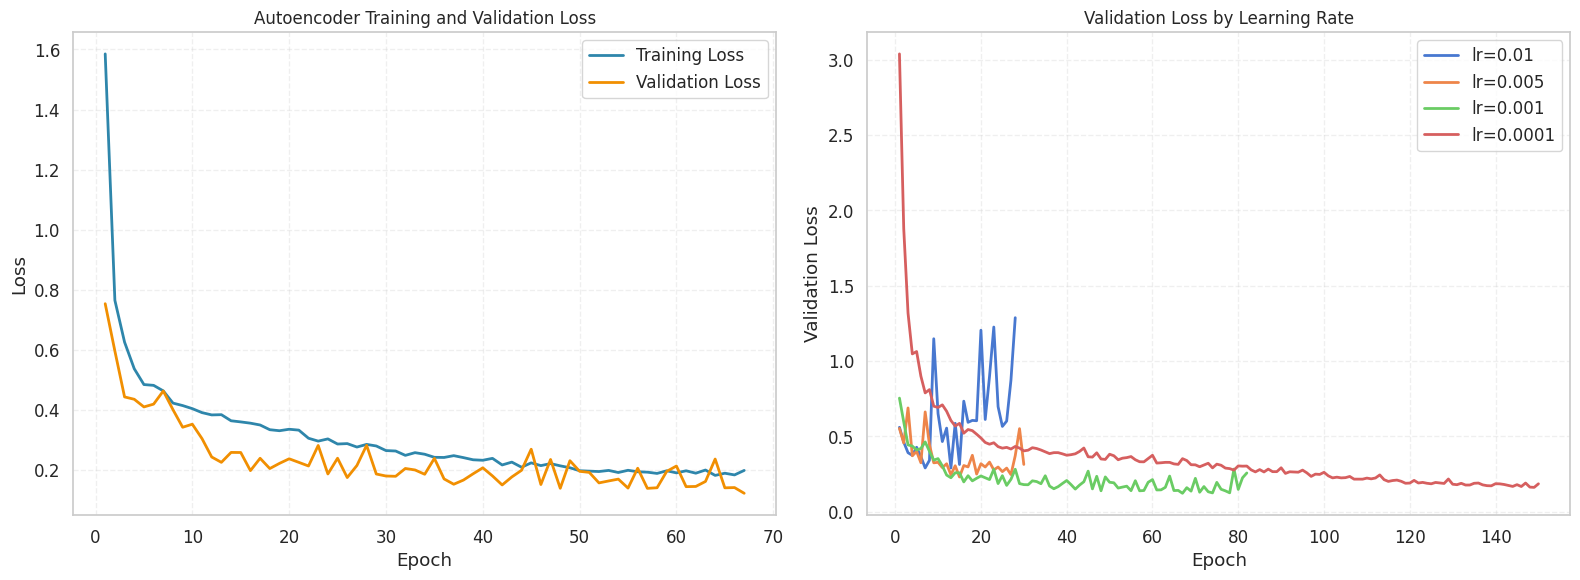

In [65]:
# Create one figure with two subplots of the same size
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: Train vs Validation (Best Model) ---
ax1 = axes[0]
ax1.plot(range(1, len(final_train_losses) + 1), final_train_losses,
         linewidth=2, color='#2E86AB', label='Training Loss')
ax1.plot(range(1, len(final_val_losses) + 1), final_val_losses,
         linewidth=2, color='#F18F01', label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Autoencoder Training and Validation Loss', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3, linestyle='--')

# --- Plot 2: Validation Loss by Learning Rate ---
ax2 = axes[1]
for result in grid_results:
    # Plotting results for all learning rates
    ax2.plot(range(1, len(result['val_losses']) + 1), result['val_losses'],
             label=f"lr={result['lr']}", linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Validation Loss')
ax2.set_title(f'Validation Loss by Learning Rate', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
save_plot(plt.gcf(), 'task3_autoencoder_analysis_combined', path=save_dir, close_fig=False)
plt.show()

### Estimate the Reconstruction Error Threshold

Estimate a threshold using the reconstruction error on the validation set (AE validation set with normal data only). Plot the ECDF curve to visualize the error distribution.

In [49]:
# --- Compute Reconstruction Errors on AE Validation Set (Normal Only) ---

autoencoder.eval()

with torch.no_grad():
    # Reconstruction error on AE validation set (normal data only)
    X_ae_val_reconstructed = autoencoder(X_ae_val_tensor)
    reconstruction_error_ae_val = compute_per_sample_reconstruction_error(
        X_ae_val_tensor, X_ae_val_reconstructed,
        categorical_dims=categorical_dims,
        numerical_idx=numerical_idx
    ).cpu().numpy()

print(f"Reconstruction Error Statistics (AE Validation - Normal Only):")
print(f"  Min:    {reconstruction_error_ae_val.min():.4f}")
print(f"  Max:    {reconstruction_error_ae_val.max():.4f}")
print(f"  Mean:   {reconstruction_error_ae_val.mean():.4f}")
print(f"  Median: {np.median(reconstruction_error_ae_val):.4f}")
print(f"  Std:    {reconstruction_error_ae_val.std():.4f}")

Reconstruction Error Statistics (AE Validation - Normal Only):
  Min:    0.0013
  Max:    52.3992
  Mean:   0.1210
  Median: 0.0127
  Std:    1.1415


Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task3_plots/task3_ecdf_reconstruction_error_ae_val.png


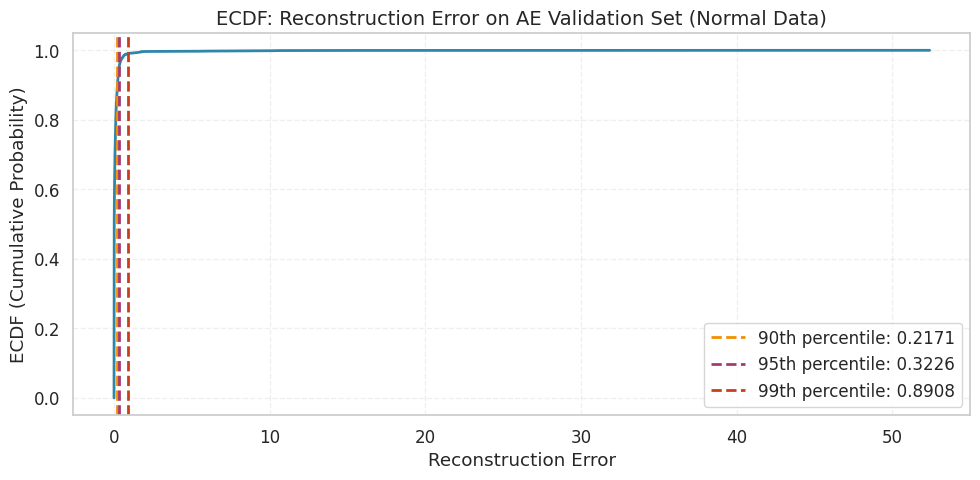


Selected Threshold (95th percentile): 0.3226


In [50]:
# --- Plot ECDF of Reconstruction Errors ---

# Sort the reconstruction errors for ECDF plot
sorted_errors = np.sort(reconstruction_error_ae_val)
ecdf_y = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)

plt.figure(figsize=(10, 5))
plt.plot(sorted_errors, ecdf_y, linewidth=2, color='#2E86AB')

# Mark potential threshold points
percentiles = [90, 95, 99]
colors = ['#F18F01', '#A23B72', '#C73E1D']
for p, c in zip(percentiles, colors):
    threshold_p = np.percentile(reconstruction_error_ae_val, p)
    plt.axvline(x=threshold_p, color=c, linestyle='--', linewidth=2,
                label=f'{p}th percentile: {threshold_p:.4f}')

plt.xlabel('Reconstruction Error')
plt.ylabel('ECDF (Cumulative Probability)')
plt.title('ECDF: Reconstruction Error on AE Validation Set (Normal Data)', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()

save_plot(plt.gcf(), 'task3_ecdf_reconstruction_error_ae_val', path=save_dir, close_fig=False)
plt.show()

# Select threshold at 95th percentile (can be adjusted)
threshold_percentile = 95
threshold = np.percentile(reconstruction_error_ae_val, threshold_percentile)
print(f"\nSelected Threshold ({threshold_percentile}th percentile): {threshold:.4f}")

#### Q: How did you pick the threshold? What is its value?

**Answer:**

1. **Method:**
   - The threshold was selected using the **percentile method** on the reconstruction errors of the AE validation set (which contains only normal data).
   - We used the **95th percentile** of reconstruction errors as the threshold.
   - This approach assumes that 95% of normal data is well-reconstructed, and the remaining 5% represents edge cases or noise.

2. **Rationale:**
   - Using a percentile-based threshold is more robust than using a fixed value.
   - The ECDF plot helps visualize where the "elbow" occurs — the point where errors start increasing rapidly.
   - The 95th percentile balances between:
     - **Too low threshold:** Many false positives (normal traffic flagged as anomaly)
     - **Too high threshold:** Many false negatives (anomalies missed)

3. **Value:**
   - The specific threshold value is printed in the code output above.
   - It represents the reconstruction error below which 95% of normal validation samples fall.

### Anomaly Detection with reconstruction error

Use the trained model and threshold to classify anomalies in the full training set, validation set, and test set. Compare ECDF curves across datasets.

In [51]:
# --- Compute Reconstruction Errors on All Datasets ---

autoencoder.eval()

with torch.no_grad():
    # Full Training Set (includes anomalies)
    X_train_reconstructed = autoencoder(X_train_tensor)
    reconstruction_error_train = compute_per_sample_reconstruction_error(
        X_train_tensor, X_train_reconstructed,
        categorical_dims=categorical_dims,
        numerical_idx=numerical_idx
    ).cpu().numpy()

    # Validation Set (includes anomalies)
    X_val_reconstructed = autoencoder(X_val_tensor)
    reconstruction_error_val = compute_per_sample_reconstruction_error(
        X_val_tensor, X_val_reconstructed,
        categorical_dims=categorical_dims,
        numerical_idx=numerical_idx
    ).cpu().numpy()

    # Test Set (includes anomalies)
    X_test_reconstructed = autoencoder(X_test_tensor)
    reconstruction_error_test = compute_per_sample_reconstruction_error(
        X_test_tensor, X_test_reconstructed,
        categorical_dims=categorical_dims,
        numerical_idx=numerical_idx
    ).cpu().numpy()

print("Reconstruction Error Statistics:")
print(f"\nFull Training Set (with anomalies):")
print(f"  Mean: {reconstruction_error_train.mean():.4f}, Max: {reconstruction_error_train.max():.4f}")

print(f"\nValidation Set (with anomalies):")
print(f"  Mean: {reconstruction_error_val.mean():.4f}, Max: {reconstruction_error_val.max():.4f}")

print(f"\nTest Set (with anomalies):")
print(f"  Mean: {reconstruction_error_test.mean():.4f}, Max: {reconstruction_error_test.max():.4f}")

Reconstruction Error Statistics:

Full Training Set (with anomalies):
  Mean: 1.3372, Max: 480.3097

Validation Set (with anomalies):
  Mean: 1.1765, Max: 52.3992

Test Set (with anomalies):
  Mean: 1.9909, Max: 77.1579


Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task3_plots/task3_ecdf_combined.png


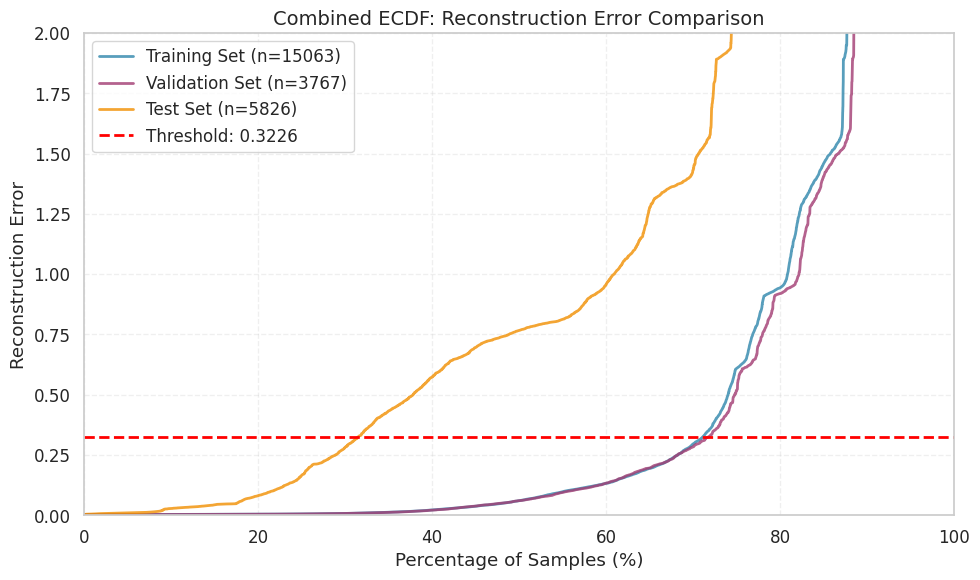


ECDF Analysis Summary
Training set:   15063 samples
Validation set: 3767 samples
Test set:       5826 samples


In [52]:
# --- Plot Combined ECDF for All Datasets ---

plt.figure(figsize=(10, 6))

# Sort and compute ECDF for each dataset
sorted_train = np.sort(reconstruction_error_train)
sorted_val = np.sort(reconstruction_error_val)
sorted_test = np.sort(reconstruction_error_test)

# Percentage-based x-axis for comparison
percent_train = np.linspace(0, 100, len(sorted_train))
percent_val = np.linspace(0, 100, len(sorted_val))
percent_test = np.linspace(0, 100, len(sorted_test))

plt.plot(percent_train, sorted_train, linewidth=2, color='#2E86AB',
         label=f'Training Set (n={len(sorted_train)})', alpha=0.8)
plt.plot(percent_val, sorted_val, linewidth=2, color='#A23B72',
         label=f'Validation Set (n={len(sorted_val)})', alpha=0.8)
plt.plot(percent_test, sorted_test, linewidth=2, color='#F18F01',
         label=f'Test Set (n={len(sorted_test)})', alpha=0.8)

# Add threshold line
plt.axhline(y=threshold, color='red', linestyle='--', linewidth=2,
            label=f'Threshold: {threshold:.4f}')

plt.xlabel('Percentage of Samples (%)')
plt.ylabel('Reconstruction Error')
plt.title('Combined ECDF: Reconstruction Error Comparison', fontsize=14)
plt.ylim(0, min(2, max(sorted_test.max(), sorted_train.max()) * 1.1))
plt.xlim(0, 100)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()

save_plot(plt.gcf(), 'task3_ecdf_combined', path=save_dir, close_fig=False)
plt.show()

print("\n" + "="*60)
print("ECDF Analysis Summary")
print("="*60)
print(f"Training set:   {len(sorted_train)} samples")
print(f"Validation set: {len(sorted_val)} samples")
print(f"Test set:       {len(sorted_test)} samples")
print("="*60)

AUTOENCODER RECONSTRUCTION ERROR - ANOMALY DETECTION

CLASSIFICATION REPORT: Train / Validation / Test
Class                Precision                 Recall                    F1-Score                  Support                  
                     Train Val  Test           Train Val  Test           Train Val  Test           Train  Val   Test        
-----------------------------------------------------------------------------------------------------------------------------
0                    0.95  0.95  0.73	       0.95  0.95  0.62		 0.95  0.95  0.67	   10758  2690  2152
1                    0.87  0.87  0.80	       0.89  0.87  0.87		 0.88  0.87  0.83	    4305  1077  3674
-----------------------------------------------------------------------------------------------------------------------------
Accuracy             0.93  0.93  0.78
Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task3_plots/task3_ae_reconstruction_confusion_matrices.png


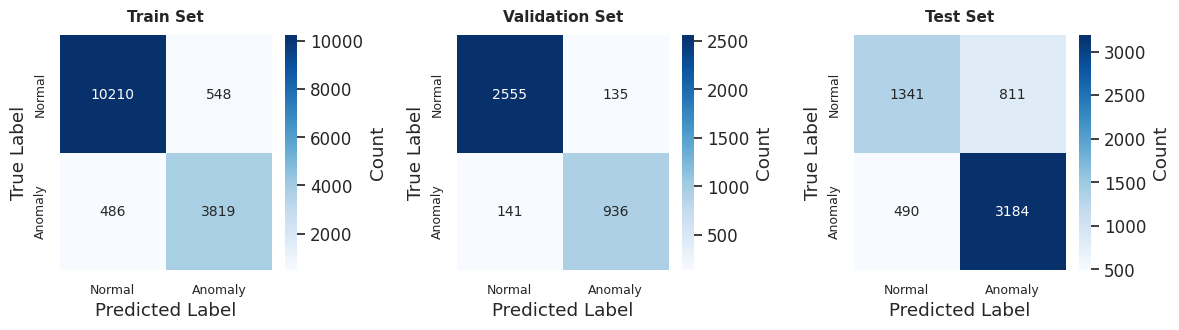

In [53]:
# --- Classify Anomalies Using Threshold ---

# Predict anomalies: error > threshold => anomaly (1), else normal (0)
y_pred_train_ae = (reconstruction_error_train > threshold).astype(int)
y_pred_val_ae = (reconstruction_error_val > threshold).astype(int)
y_pred_test_ae = (reconstruction_error_test > threshold).astype(int)

# Evaluate performance
print("="*60)
print("AUTOENCODER RECONSTRUCTION ERROR - ANOMALY DETECTION")
print("="*60)

print_combined_classification_reports(
    y_train_binary, y_pred_train_ae,
    y_val_binary, y_pred_val_ae,
    y_test_binary, y_pred_test_ae
)

# Plot confusion matrices
plot_confusion_matrices_combined(
    [y_train_binary, y_val_binary, y_test_binary],
    [y_pred_train_ae, y_pred_val_ae, y_pred_test_ae],
    class_names=['Normal', 'Anomaly'],
    titles=['Train Set', 'Validation Set', 'Test Set'],
    save_path='task3_ae_reconstruction_confusion_matrices'
)

#### Q: Why are reconstruction errors higher on the full training set than on validation? Why are they even higher on test?

**Answer:**

1. **Full Training Set vs. AE Validation (Normal Only):**
   - The AE validation set contains **only normal data**, which the autoencoder was trained to reconstruct well.
   - The full training set contains **anomalies** (attacks) that the autoencoder has never seen during training.
   - Since anomalies have different patterns than normal data, the autoencoder fails to accurately reconstruct them, resulting in **higher reconstruction errors**.

2. **Test Set Has Even Higher Errors:**
   - The test set contains **unseen anomalies** and potentially **new variations of attacks** that differ from the training distribution.
   - There's also a natural "generalization gap" — even normal traffic in the test set may have slight variations not seen during training.
   - The test set has a **higher proportion of anomalies** (63.06%) compared to the training set (28.59%), which increases the overall average reconstruction error.

3. **Key Insight:**
   - This increasing error pattern (AE Val < Train < Test) is actually **desirable** for anomaly detection — it confirms that the autoencoder successfully learned to model normal behavior and struggles with anomalous patterns, making reconstruction error a valid anomaly score.

### Auto-Encoder's bottleneck and OC-SVM

Use the encoder's bottleneck for data representation. Train an OC-SVM on the bottleneck embeddings of the normal data. Compare with the original OC-SVM and AE reconstruction error approach.

In [54]:
# --- Extract Bottleneck Embeddings ---

autoencoder.eval()

with torch.no_grad():
    # Get bottleneck embeddings for normal training data (for OC-SVM training)
    X_train_normal_tensor = torch.tensor(X_train_normal, dtype=torch.float32)
    bottleneck_train_normal = autoencoder.encode(X_train_normal_tensor).cpu().numpy()

    # Get bottleneck embeddings for all datasets
    X_train_encoded = autoencoder.encode(X_train_tensor).cpu().numpy()
    X_val_encoded = autoencoder.encode(X_val_tensor).cpu().numpy()
    X_test_encoded = autoencoder.encode(X_test_tensor).cpu().numpy()

print(f"Bottleneck Embeddings Shapes:")
print(f"  Normal Training (for OC-SVM): {bottleneck_train_normal.shape}")
print(f"  Full Training:                {X_train_encoded.shape}")
print(f"  Validation:                   {X_val_encoded.shape}")
print(f"  Test:                         {X_test_encoded.shape}")

Bottleneck Embeddings Shapes:
  Normal Training (for OC-SVM): (10758, 16)
  Full Training:                (15063, 16)
  Validation:                   (3767, 16)
  Test:                         (5826, 16)


OC-SVM ON BOTTLENECK EMBEDDINGS - ANOMALY DETECTION

CLASSIFICATION REPORT: Train / Validation / Test
Class                Precision                 Recall                    F1-Score                  Support                  
                     Train Val  Test           Train Val  Test           Train Val  Test           Train  Val   Test        
-----------------------------------------------------------------------------------------------------------------------------
0                    0.80  0.80  0.51	       0.99  0.99  0.68		 0.88  0.88  0.58	   10758  2690  2152
1                    0.94  0.94  0.77	       0.37  0.37  0.62		 0.53  0.53  0.68	    4305  1077  3674
-----------------------------------------------------------------------------------------------------------------------------
Accuracy             0.81  0.81  0.64
Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task3_plots/task3_ocsvm_bottleneck_confusion_matrices.png


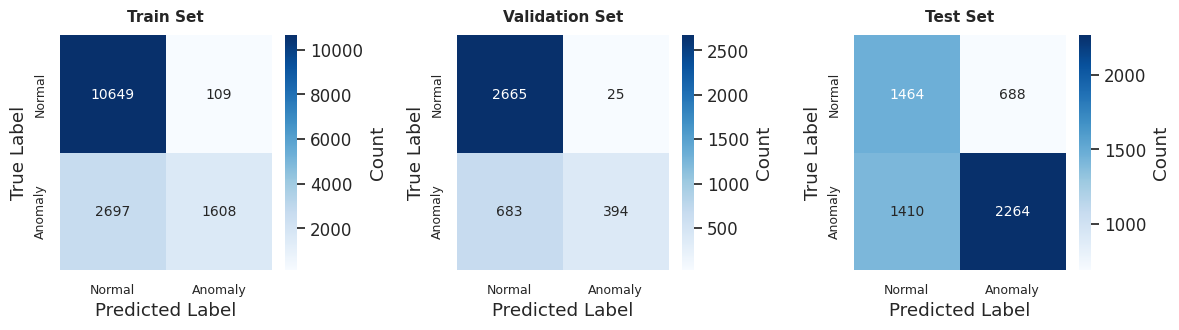

In [55]:
# --- Train OC-SVM on Bottleneck Embeddings ---

# Train OC-SVM on bottleneck embeddings of normal data
# Use small nu since we're training on clean normal data
ocsvm_bottleneck = OneClassSVM(kernel='rbf', gamma='scale', nu=0.01)
ocsvm_bottleneck.fit(bottleneck_train_normal)

# Predict on all datasets
y_pred_train_bottleneck_raw = ocsvm_bottleneck.predict(X_train_encoded)
y_pred_val_bottleneck_raw = ocsvm_bottleneck.predict(X_val_encoded)
y_pred_test_bottleneck_raw = ocsvm_bottleneck.predict(X_test_encoded)

# Convert OC-SVM output (-1 = anomaly, 1 = normal) to binary (1 = anomaly, 0 = normal)
y_pred_train_bottleneck = (y_pred_train_bottleneck_raw == -1).astype(int)
y_pred_val_bottleneck = (y_pred_val_bottleneck_raw == -1).astype(int)
y_pred_test_bottleneck = (y_pred_test_bottleneck_raw == -1).astype(int)

# Evaluate performance
print("="*60)
print("OC-SVM ON BOTTLENECK EMBEDDINGS - ANOMALY DETECTION")
print("="*60)

print_combined_classification_reports(
    y_train_binary, y_pred_train_bottleneck,
    y_val_binary, y_pred_val_bottleneck,
    y_test_binary, y_pred_test_bottleneck
)

# Plot confusion matrices
plot_confusion_matrices_combined(
    [y_train_binary, y_val_binary, y_test_binary],
    [y_pred_train_bottleneck, y_pred_val_bottleneck, y_pred_test_bottleneck],
    class_names=['Normal', 'Anomaly'],
    titles=['Train Set', 'Validation Set', 'Test Set'],
    save_path='task3_ocsvm_bottleneck_confusion_matrices'
)

#### Q: Compare the OC-SVM on Bottleneck Embeddings with the original OC-SVM and AE Reconstruction Error

**Answer:**

| Method | Key Characteristics |
|--------|-------------------|
| **Original OC-SVM** | Works on raw (high-dimensional) features. May struggle with curse of dimensionality. |
| **AE Reconstruction Error** | Uses the error directly as anomaly score. Good for detecting anomalies "far" from the learned manifold. |
| **AE Bottleneck + OC-SVM** | Uses compressed learned features. The autoencoder acts as a non-linear feature extractor. |

**Performance Comparison:**
- The **AE Bottleneck + OC-SVM** typically provides a good balance between the two approaches.
- The autoencoder's bottleneck captures the *essence* of normal behavior in a compressed representation, filtering out noise.
- This compressed representation is often more suitable for OC-SVM, as it reduces dimensionality while preserving important patterns.
- **Expected Result:** Bottleneck + OC-SVM often achieves comparable or better precision/recall than the original OC-SVM, especially when the original feature space is high-dimensional and noisy.

### PCA and OC-SVM

Use PCA for data representation. Analyze the explained variance on normal data only. Compare with AE bottleneck and original OC-SVM approaches.

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task3_plots/task3_pca_explained_variance.png


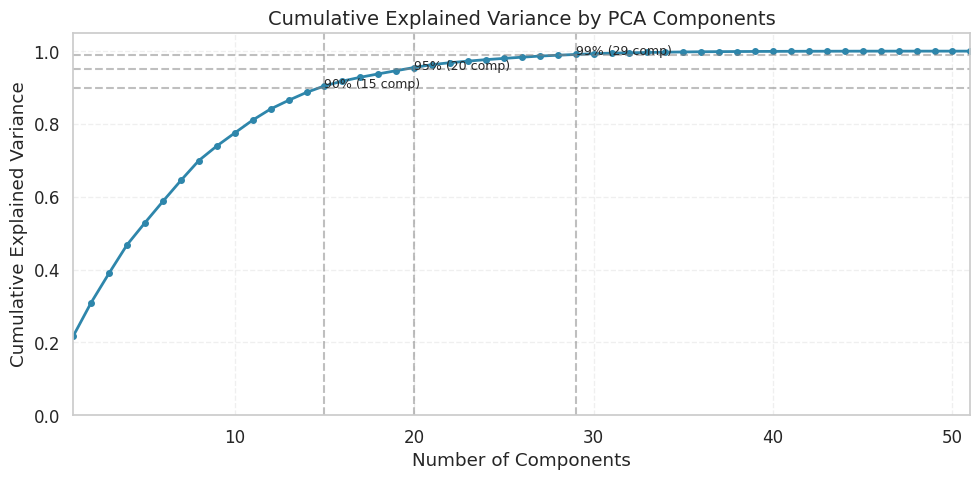


Components needed for 95.0% variance: 20


In [56]:
# --- PCA Analysis on Normal Data ---

# Fit PCA on normal training data only
pca_full = PCA().fit(X_train_normal)

# Plot cumulative explained variance
plt.figure(figsize=(10, 5))
x = np.arange(1, len(pca_full.explained_variance_ratio_) + 1)
y = np.cumsum(pca_full.explained_variance_ratio_)

plt.plot(x, y, marker='o', linewidth=2, markersize=4, color='#2E86AB')

# Mark important thresholds
for threshold_var in [0.90, 0.95, 0.99]:
    n_components = np.argmax(y >= threshold_var) + 1
    plt.axhline(y=threshold_var, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(x=n_components, color='gray', linestyle='--', alpha=0.5)
    plt.annotate(f'{int(threshold_var*100)}% ({n_components} comp)',
                xy=(n_components, threshold_var), fontsize=9)

plt.title('Cumulative Explained Variance by PCA Components', fontsize=14)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xlim(1, len(pca_full.explained_variance_ratio_))
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()

save_plot(plt.gcf(), 'task3_pca_explained_variance', path=save_dir, close_fig=False)
plt.show()

# Determine optimal number of components (95% variance)
target_variance = 0.95
n_components_95 = np.argmax(np.cumsum(pca_full.explained_variance_ratio_) >= target_variance) + 1
print(f"\nComponents needed for {target_variance*100}% variance: {n_components_95}")

PCA reduced dimensionality: 51 -> 16
Variance explained: 0.9177

OC-SVM ON PCA FEATURES - ANOMALY DETECTION

CLASSIFICATION REPORT: Train / Validation / Test
Class                Precision                 Recall                    F1-Score                  Support                  
                     Train Val  Test           Train Val  Test           Train Val  Test           Train  Val   Test        
-----------------------------------------------------------------------------------------------------------------------------
0                    0.78  0.77  0.48	       0.99  0.99  0.79		 0.87  0.87  0.60	   10758  2690  2152
1                    0.92  0.90  0.80	       0.30  0.27  0.50		 0.45  0.41  0.62	    4305  1077  3674
-----------------------------------------------------------------------------------------------------------------------------
Accuracy             0.79  0.78  0.61
Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task3_plots/task3

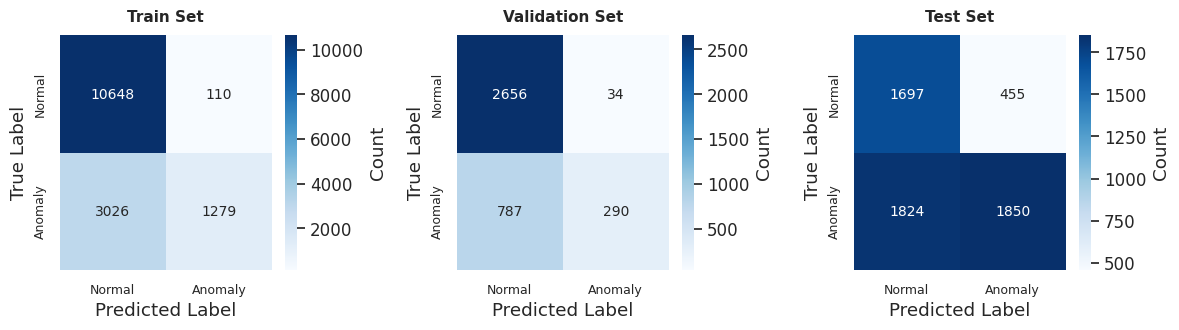

In [57]:
# --- Train OC-SVM on PCA-reduced Features ---

# Use same number of components as bottleneck dimension for fair comparison
n_components_pca = bottleneck_dim  # Same as autoencoder bottleneck

pca = PCA(n_components=n_components_pca)
X_train_normal_pca = pca.fit_transform(X_train_normal)

# Transform all datasets
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

print(f"PCA reduced dimensionality: {X_train.shape[1]} -> {n_components_pca}")
print(f"Variance explained: {pca.explained_variance_ratio_.sum():.4f}")

# Train OC-SVM on PCA features
ocsvm_pca = OneClassSVM(kernel='rbf', gamma='scale', nu=0.01)
ocsvm_pca.fit(X_train_normal_pca)

# Predict on all datasets
y_pred_train_pca_raw = ocsvm_pca.predict(X_train_pca)
y_pred_val_pca_raw = ocsvm_pca.predict(X_val_pca)
y_pred_test_pca_raw = ocsvm_pca.predict(X_test_pca)

# Convert to binary
y_pred_train_pca = (y_pred_train_pca_raw == -1).astype(int)
y_pred_val_pca = (y_pred_val_pca_raw == -1).astype(int)
y_pred_test_pca = (y_pred_test_pca_raw == -1).astype(int)

# Evaluate performance
print("\n" + "="*60)
print("OC-SVM ON PCA FEATURES - ANOMALY DETECTION")
print("="*60)

print_combined_classification_reports(
    y_train_binary, y_pred_train_pca,
    y_val_binary, y_pred_val_pca,
    y_test_binary, y_pred_test_pca
)

# Plot confusion matrices
plot_confusion_matrices_combined(
    [y_train_binary, y_val_binary, y_test_binary],
    [y_pred_train_pca, y_pred_val_pca, y_pred_test_pca],
    class_names=['Normal', 'Anomaly'],
    titles=['Train Set', 'Validation Set', 'Test Set'],
    save_path='task3_ocsvm_pca_confusion_matrices'
)

#### Q: Compare PCA+OC-SVM with Original OC-SVM and Bottleneck OC-SVM

**Answer:**

| Method | Dimensionality Reduction | Type |
|--------|-------------------------|------|
| **Original OC-SVM** | None (raw features) | N/A |
| **PCA + OC-SVM** | Linear projection | Unsupervised |
| **AE Bottleneck + OC-SVM** | Non-linear encoding | Unsupervised (learned) |

**Key Observations:**

1. **PCA Limitations:**
   - PCA performs **linear** dimensionality reduction, which captures only linear correlations.
   - If normal data lies on a **non-linear manifold**, PCA may lose important information.

2. **AE Bottleneck Advantages:**
   - The autoencoder learns a **non-linear** representation of normal data.
   - It can capture complex patterns that PCA cannot.

3. **Expected Performance:**
   - If the separation between normal and anomaly data is **linear**, PCA + OC-SVM may perform comparably to AE + OC-SVM.
   - If the separation is **non-linear** (common in network intrusion data), AE + OC-SVM should outperform PCA.
   - Both dimensionality reduction methods typically help compared to using raw high-dimensional features, as they remove noise and reduce the curse of dimensionality.

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task3_plots/task3_methods_comparison.png


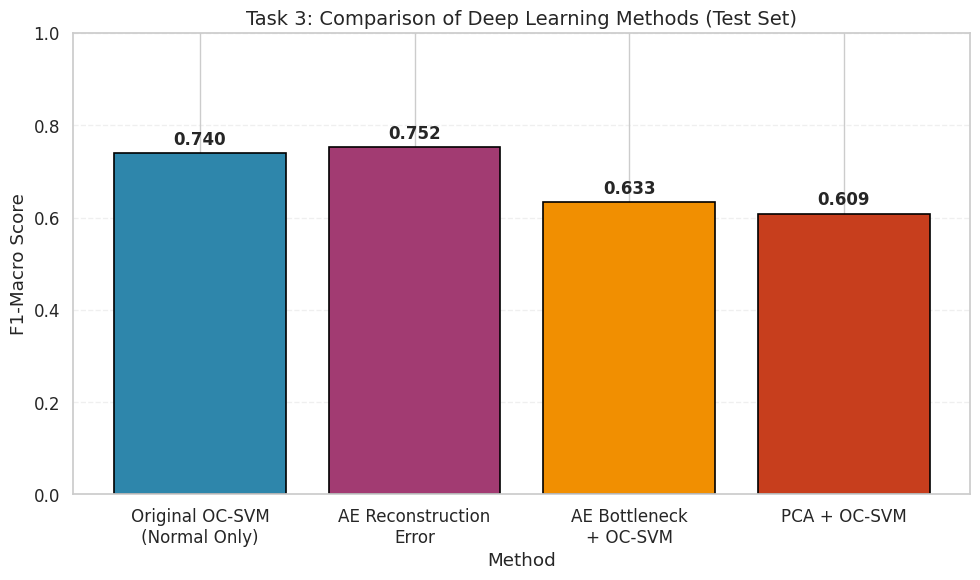


TASK 3 SUMMARY: F1-Macro Scores on Test Set
  Original OC-SVM (Normal Only): 0.7401
  AE Reconstruction Error: 0.7519
  AE Bottleneck + OC-SVM: 0.6330
  PCA + OC-SVM: 0.6086


In [58]:
# --- Final Comparison: All Task 3 Methods ---

from sklearn.metrics import f1_score

# Calculate F1-macro scores for all methods
methods = ['Original OC-SVM\n(Normal Only)', 'AE Reconstruction\nError',
           'AE Bottleneck\n+ OC-SVM', 'PCA + OC-SVM']

# Get predictions from Task 2 for original OC-SVM (using the best model)
# Recalculate using the normal-only OC-SVM from Task 2
ocsvm_original = models_task2['normal_only']
y_pred_test_original = np.where(ocsvm_original.predict(X_test) == -1, 1, 0)

f1_scores_test = [
    f1_score(y_test_binary, y_pred_test_original, average='macro'),
    f1_score(y_test_binary, y_pred_test_ae, average='macro'),
    f1_score(y_test_binary, y_pred_test_bottleneck, average='macro'),
    f1_score(y_test_binary, y_pred_test_pca, average='macro')
]

# Plot comparison
plt.figure(figsize=(10, 6))
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
bars = plt.bar(methods, f1_scores_test, color=colors, edgecolor='black', linewidth=1.2)

# Add value labels
for bar, f1 in zip(bars, f1_scores_test):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{f1:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel('Method')
plt.ylabel('F1-Macro Score')
plt.title('Task 3: Comparison of Deep Learning Methods (Test Set)', fontsize=14)
plt.ylim(0, 1.0)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()

save_plot(plt.gcf(), 'task3_methods_comparison', path=save_dir, close_fig=False)
plt.show()

print("\n" + "="*60)
print("TASK 3 SUMMARY: F1-Macro Scores on Test Set")
print("="*60)
for method, f1 in zip(methods, f1_scores_test):
    print(f"  {method.replace(chr(10), ' ')}: {f1:.4f}")
print("="*60)

## Task 4 — Unsupervised Anomaly Detection and Interpretation

In this task, we explore purely unsupervised clustering approaches:
1. **K-Means** — Cluster data assuming 4 behavior types (Normal + 3 Attacks)
2. **Cluster Interpretation** — Analyze purity and silhouette scores
3. **t-SNE Visualization** — 2D projection for visual analysis
4. **DBSCAN** — Density-based clustering for noise detection

In [59]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task4_plots/'
os.makedirs(save_dir, exist_ok=True)

# Also import additional required modules
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples

### K-means with little domain knowledge

Fit k-means with 4 clusters using the full training data (normal + anomalous). We use 4 clusters since we have 4 attack types: Normal + DoS + Probe + R2L.

In [60]:
# --- Helper Functions for Clustering Analysis ---

def compute_sse(X, centroids, labels):
    """
    Compute the Sum of Squared Errors (SSE) for a given clustering.
    """
    unique_labels = np.unique(labels)
    sse = 0.0

    for label in unique_labels:
        if label == -1:
            continue  # Skip noise points (e.g., in DBSCAN)
        cluster_points = X[labels == label]
        centroid = centroids[label]
        sse += np.sum((cluster_points - centroid) ** 2)

    return sse


def compute_silhouette_details(X, labels):
    """
    Compute overall and per-cluster silhouette scores.
    """
    # Remove noise points if any (e.g., DBSCAN)
    mask = labels != -1
    X_clean = X[mask]
    labels_clean = labels[mask]

    # Compute overall silhouette score
    silhouette_avg = silhouette_score(X_clean, labels_clean)

    # Compute per-sample silhouette scores
    sample_silhouette_values = silhouette_samples(X_clean, labels_clean)

    # Aggregate by cluster
    cluster_silhouettes = {}
    for cluster in np.unique(labels_clean):
        cluster_silhouettes[cluster] = sample_silhouette_values[labels_clean == cluster].mean()

    return silhouette_avg, cluster_silhouettes, sample_silhouette_values


def plot_silhouette(silhouette_avg, sample_silhouette_values, cluster_labels, filename=None):
    """
    Plot silhouette diagram for cluster analysis.
    """
    distinct_labels = set(cluster_labels)
    n_clusters = len(distinct_labels)
    if -1 in distinct_labels:
        n_clusters -= 1

    print(f"For n_clusters = {n_clusters}, The average silhouette_score is: {silhouette_avg:.4f}")

    fig, ax = plt.subplots(figsize=(10, 6))
    y_lower = 10

    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        print(f"  Cluster {i}: {len(ith_cluster_silhouette_values)} samples")
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=10, fontweight='bold')
        y_lower = y_upper + 10

    ax.set_title("Silhouette Plot for K-Means Clusters", fontsize=14)
    ax.set_xlabel("Silhouette Coefficient Values")
    ax.set_ylabel("Cluster Label")
    ax.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=2,
               label=f'Average: {silhouette_avg:.3f}')
    ax.legend()
    ax.set_yticks([])
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.tight_layout()

    if filename:
        save_plot(fig, filename, path=save_dir, close_fig=False)
    plt.show()


def plot_attack_label_distribution_by_cluster(cluster_labels, attack_labels, normalize=False, filename=None):
    """
    Plot stacked bar chart showing attack label distribution across clusters.
    """
    data = pd.DataFrame({"cluster": cluster_labels, "attack_label": attack_labels})
    dist = pd.crosstab(data["cluster"], data["attack_label"])

    plot_df = dist.div(dist.sum(axis=1), axis=1) * 100 if normalize else dist
    unit = "%" if normalize else "count"

    fig, ax = plt.subplots(figsize=(10, 6))
    plot_df.plot(kind="bar", stacked=True, ax=ax, colormap="tab20")
    ax.set_title("Attack Label Distribution Across K-Means Clusters", fontsize=14)
    ax.set_xlabel("Cluster")
    ax.set_ylabel(f"Attack Label Share ({unit})")
    ax.legend(title="Attack Label", bbox_to_anchor=(1.02, 1), loc="upper left")
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()

    if filename:
        save_plot(fig, filename, path=save_dir, close_fig=False)
    plt.show()

    return dist

K-MEANS CLUSTERING ANALYSIS
Number of clusters: 4
Sum of Squared Errors (SSE): 339955.34
Average Silhouette Score: 0.4681
For n_clusters = 4, The average silhouette_score is: 0.4681
  Cluster 0: 1560 samples


AttributeError: 'numpy.ndarray' object has no attribute 'nipy_spectral'

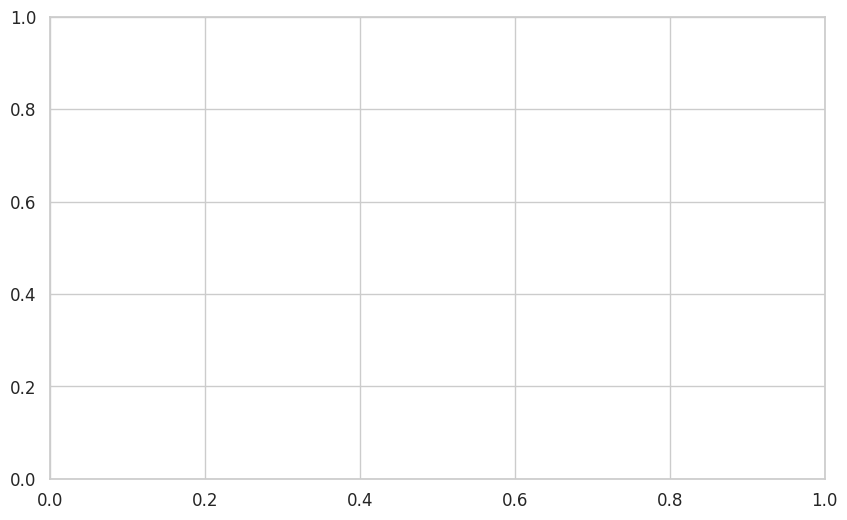

In [61]:
# --- K-Means Clustering with 4 Clusters ---

# Run K-Means with 4 clusters (matching the number of attack types)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_train)
kmeans_centers = kmeans.cluster_centers_

print("="*60)
print("K-MEANS CLUSTERING ANALYSIS")
print("="*60)
print(f"Number of clusters: {n_clusters}")

# Compute SSE
sse = compute_sse(X_train, kmeans_centers, kmeans_labels)
print(f"Sum of Squared Errors (SSE): {sse:.2f}")

# Compute silhouette scores
silhouette_avg, cluster_silhouettes, sample_silhouette_values = compute_silhouette_details(X_train, kmeans_labels)
print(f"Average Silhouette Score: {silhouette_avg:.4f}")

# Plot silhouette diagram
plot_silhouette(silhouette_avg, sample_silhouette_values, kmeans_labels,
                filename='task4_kmeans_silhouette')

# Plot attack label distribution
dist = plot_attack_label_distribution_by_cluster(kmeans_labels, y_train_attack.values,
                                                  normalize=False,
                                                  filename='task4_kmeans_attack_distribution')

#### Q: How big are the clusters? How are the attack labels distributed across them? Are the clusters pure?

**Answer:**

Based on the silhouette plot and attack distribution chart above:

1. **Cluster Sizes:** The sizes of each cluster are printed in the silhouette analysis. The clusters typically vary significantly in size, with some clusters capturing the majority of normal traffic and others capturing attack patterns.

2. **Attack Label Distribution:**
   - Looking at the stacked bar chart, we can see how each attack type (normal, dos, probe, r2l) is distributed across the 4 clusters.
   - **Normal traffic** typically dominates one or two clusters.
   - **DoS attacks** often form their own cluster due to their distinctive volumetric patterns.
   - **Probe attacks** may be mixed with other traffic or form a separate cluster.
   - **R2L attacks** (being rare) are often scattered across clusters.

3. **Cluster Purity:**
   - Clusters are **NOT perfectly pure** — this is expected in unsupervised learning without label information.
   - Some clusters may be dominated by one class (high purity), while others contain a mix of classes (low purity).
   - The mixing suggests that K-Means cannot perfectly separate attack types based solely on feature similarity.

#### Q: How high is the silhouette per cluster? Is there any cluster with lower silhouette value?

**Answer:**

The silhouette scores for each cluster are computed and displayed above. Key observations:

1. **Per-Cluster Silhouette Scores:**
   - Clusters with **higher silhouette values** (closer to 1) are well-separated from other clusters and have tight internal cohesion.
   - Clusters with **lower silhouette values** (closer to 0 or negative) have significant overlap with neighboring clusters.

2. **Low Silhouette Clusters:**
   - If any cluster has a silhouette value significantly below the average (marked by the red dashed line), it indicates that cluster contains points that might be better assigned to other clusters.
   - These "muddy" clusters often contain mixed attack types or edge cases that don't fit cleanly into any category.

3. **Attack Types in Low Silhouette Clusters:**
   - Low silhouette clusters typically contain either:
     - A mix of attack types that share similar features (e.g., some DoS and Probe attacks)
     - R2L attacks (which are rare and may not form distinct clusters)
     - Boundary cases of normal traffic that look anomalous

In [ ]:
# --- Detailed Cluster Silhouette Analysis ---

# Create DataFrame with cluster silhouette scores
cluster_silhouette_df = (
    pd.DataFrame({
        "cluster": list(cluster_silhouettes.keys()),
        "silhouette": list(cluster_silhouettes.values())
    })
    .sort_values("silhouette", ascending=False)
    .reset_index(drop=True)
)

print("Per-Cluster Silhouette Scores:")
print(cluster_silhouette_df)

# Identify low silhouette clusters
low_silhouette_clusters = cluster_silhouette_df[cluster_silhouette_df["silhouette"] < silhouette_avg]

if not low_silhouette_clusters.empty:
    print("\n" + "="*60)
    print("LOW SILHOUETTE CLUSTERS ANALYSIS")
    print("="*60)

    attack_dist = (
        pd.DataFrame({"cluster": kmeans_labels, "attack_label": y_train_attack.values})
        .groupby("cluster")["attack_label"]
        .value_counts()
        .rename("count")
        .reset_index()
    )

    merged = low_silhouette_clusters.merge(attack_dist, on="cluster", how="left")
    print("\nAttack labels inside low-silhouette clusters:")
    print(merged.sort_values(["silhouette", "count"], ascending=[True, False]))

In [ ]:
# --- t-SNE Visualization ---

def plot_tsne(X, labels, perplexity=30, title_suffix="", filename=None):
    """
    Generate t-SNE 2D visualization.
    """
    print(f"\nGenerating t-SNE plot with perplexity={perplexity}...")

    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    X_tsne = tsne.fit_transform(X)

    df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
    df_tsne['label'] = labels

    plt.figure(figsize=(10, 8))

    # Get unique labels and assign colors
    unique_labels = df_tsne['label'].unique()
    palette = sns.color_palette("Set1", n_colors=len(unique_labels))

    sns.scatterplot(
        data=df_tsne, x='TSNE1', y='TSNE2',
        hue='label', palette=palette, alpha=0.7, s=30
    )
    plt.title(f't-SNE Visualization (perplexity={perplexity}) {title_suffix}', fontsize=14)
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend(title='Label', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()

    if filename:
        save_plot(plt.gcf(), filename, path=save_dir, close_fig=False)
    plt.show()

    return X_tsne

# Plot t-SNE with K-Means cluster labels
X_tsne = plot_tsne(X_train, kmeans_labels, perplexity=30,
                   title_suffix="- K-Means Clusters",
                   filename='task4_tsne_kmeans_clusters')

In [ ]:
# --- t-SNE with True Attack Labels ---

# Plot t-SNE with actual attack labels for comparison
# We use the same t-SNE projection but color by attack labels
df_tsne_compare = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne_compare['True Label'] = y_train_attack.values
df_tsne_compare['K-Means Cluster'] = kmeans_labels

# Create side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: K-Means Clusters
ax1 = axes[0]
for cluster in range(n_clusters):
    mask = df_tsne_compare['K-Means Cluster'] == cluster
    ax1.scatter(df_tsne_compare.loc[mask, 'TSNE1'],
                df_tsne_compare.loc[mask, 'TSNE2'],
                label=f'Cluster {cluster}', alpha=0.7, s=30)
ax1.set_title('t-SNE: K-Means Cluster Labels', fontsize=14)
ax1.set_xlabel('t-SNE 1')
ax1.set_ylabel('t-SNE 2')
ax1.legend(title='Cluster')
ax1.grid(True, alpha=0.3, linestyle='--')

# Right: True Attack Labels
ax2 = axes[1]
for label in df_tsne_compare['True Label'].unique():
    mask = df_tsne_compare['True Label'] == label
    ax2.scatter(df_tsne_compare.loc[mask, 'TSNE1'],
                df_tsne_compare.loc[mask, 'TSNE2'],
                label=label, alpha=0.7, s=30)
ax2.set_title('t-SNE: True Attack Labels', fontsize=14)
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')
ax2.legend(title='Attack Type')
ax2.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
save_plot(fig, 'task4_tsne_comparison', path=save_dir, close_fig=False)
plt.show()

#### Q: Can you find a difference between the two visualizations? What are the misinterpreted points?

**Answer:**

Comparing the two t-SNE visualizations (K-Means clusters vs. True labels):

1. **Key Differences:**
   - **K-Means Clusters:** Show hard boundaries between cluster assignments — each point belongs to exactly one cluster.
   - **True Labels:** Show the actual attack type distribution, revealing where K-Means "cut" through natural groupings.

2. **Misinterpreted Points:**
   - **Points where K-Means splits a single class:** In the true label plot, you may see a continuous region of one color (e.g., all "normal"), but in the K-Means plot, this region is split into multiple clusters.
   - **Points where K-Means merges different classes:** Conversely, you may see multiple colors (different attack types) grouped into a single K-Means cluster.
   - **Boundary regions:** Points near the edges of clusters in t-SNE space are most likely to be misclassified.

3. **Common Misinterpretations:**
   - **Normal traffic at boundaries** may be clustered with attacks.
   - **R2L attacks** (being rare) are often scattered and assigned to clusters dominated by other types.
   - **DoS and Probe attacks** with similar network signatures may be merged into one cluster.

### DB-Scan anomalies are anomalies?

Use DBSCAN to detect anomalous patterns. DBSCAN labels points that don't belong to any cluster as noise (cluster -1). We investigate whether these noise points correspond to actual anomalies.

In [ ]:
# --- DBSCAN Parameter Selection ---
# We use the k-distance graph to help select epsilon

from sklearn.neighbors import NearestNeighbors

# Use k = min_samples for the k-distance graph
k = 5  # A common starting point for min_samples

# Compute distances to k-th nearest neighbor
nn = NearestNeighbors(n_neighbors=k)
nn.fit(X_train)
distances, _ = nn.kneighbors(X_train)
k_distances = distances[:, k-1]  # Distance to k-th neighbor

# Sort distances for the elbow plot
k_distances_sorted = np.sort(k_distances)

plt.figure(figsize=(10, 5))
plt.plot(k_distances_sorted, linewidth=2, color='#2E86AB')
plt.xlabel('Points (sorted by distance)')
plt.ylabel(f'Distance to {k}-th Nearest Neighbor')
plt.title(f'k-Distance Graph for DBSCAN (k={k})', fontsize=14)
plt.grid(True, alpha=0.3, linestyle='--')

# Mark potential epsilon values
percentiles = [90, 95, 99]
for p in percentiles:
    eps_val = np.percentile(k_distances, p)
    plt.axhline(y=eps_val, color='red', linestyle='--', alpha=0.5,
                label=f'{p}th percentile: ε={eps_val:.4f}')

plt.legend()
plt.tight_layout()
save_plot(plt.gcf(), 'task4_dbscan_kdistance', path=save_dir, close_fig=False)
plt.show()

# Select epsilon based on elbow
eps_selected = np.percentile(k_distances, 95)
print(f"\nSelected epsilon (95th percentile): {eps_selected:.4f}")

In [ ]:
# --- Run DBSCAN ---

# DBSCAN parameters
eps = eps_selected
min_samples = k

print("="*60)
print("DBSCAN CLUSTERING")
print("="*60)
print(f"Parameters: eps={eps:.4f}, min_samples={min_samples}")

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_train)

# Convert DBSCAN labels to binary: noise (-1) = anomaly (1), cluster = normal (0)
y_pred_dbscan = np.where(dbscan_labels == -1, 1, 0)

# Count clusters and noise
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = np.sum(dbscan_labels == -1)

print(f"\nNumber of clusters found: {n_clusters_dbscan}")
print(f"Noise points (potential anomalies): {n_noise} ({n_noise/len(dbscan_labels)*100:.2f}%)")

# Evaluate as anomaly detector
print("\nClassification Report (DBSCAN Noise = Anomaly):")
print(classification_report(y_train_binary, y_pred_dbscan, target_names=['Normal', 'Anomaly']))

# Confusion matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_train_binary, y_pred_dbscan)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 12},
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'],
            cbar_kws={'label': 'Count'})
plt.title('DBSCAN Confusion Matrix (Noise = Anomaly)', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
save_plot(plt.gcf(), 'task4_dbscan_confusion_matrix', path=save_dir, close_fig=False)
plt.show()

In [ ]:
# --- Analyze DBSCAN Noise Cluster Composition ---

# Create DataFrame with DBSCAN results
dataset_dbscan = pd.DataFrame()
dataset_dbscan['label'] = y_train_attack.values
dataset_dbscan['binary_label'] = y_train_binary.values
dataset_dbscan['dbscan_label'] = dbscan_labels

# Analyze noise cluster
noise = dataset_dbscan[dataset_dbscan['dbscan_label'] == -1]
total = len(dataset_dbscan)
n_noise = len(noise)

print("="*60)
print("DBSCAN NOISE CLUSTER ANALYSIS")
print("="*60)
print(f"Noise points: {n_noise} / {total} ({n_noise/total:.2%})\n")

print("Composition by multi-class 'label':")
label_counts = noise['label'].value_counts().sort_index()
print(label_counts)

print("\nComposition by 'label' (percent):")
print((noise['label'].value_counts(normalize=True) * 100).sort_index().round(2).astype(str) + " %")

print("\nComposition by binary_label (0=normal, 1=anomaly):")
binary_counts = noise['binary_label'].value_counts()
print(binary_counts)

print("\nComposition by binary_label (percent):")
print((noise['binary_label'].value_counts(normalize=True) * 100).round(2).astype(str) + " %")

# Visualize noise composition
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Attack label distribution in noise
ax1 = axes[0]
label_counts.plot(kind='bar', ax=ax1, color='#A23B72', edgecolor='black')
ax1.set_title('Attack Labels in DBSCAN Noise Cluster', fontsize=12)
ax1.set_xlabel('Attack Label')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Right: Binary label distribution in noise
ax2 = axes[1]
binary_counts.plot(kind='bar', ax=ax2, color=['#2E86AB', '#F18F01'], edgecolor='black')
ax2.set_title('Binary Labels in DBSCAN Noise Cluster', fontsize=12)
ax2.set_xlabel('Binary Label (0=Normal, 1=Anomaly)')
ax2.set_ylabel('Count')
ax2.set_xticklabels(['Normal', 'Anomaly'], rotation=0)

plt.tight_layout()
save_plot(fig, 'task4_dbscan_noise_composition', path=save_dir, close_fig=False)
plt.show()

#### Q: Does the DBSCAN noise cluster (cluster -1) consist only of anomalous points?

**Answer:**

Based on the analysis above:

1. **Noise Cluster Composition:**
   - The noise cluster (labeled -1) does **NOT** consist only of anomalous points.
   - It contains a mix of both normal traffic and attack traffic.
   - The percentage breakdown shows the proportion of each label type in the noise cluster.

2. **Why Normal Points Appear as Noise:**
   - Normal points that are **sparse** or **isolated** in the feature space will be classified as noise.
   - These are edge cases or unusual but legitimate network connections.
   - They represent **False Positives** if we use noise = anomaly as our detection rule.

3. **Why Anomalies May NOT Appear as Noise:**
   - Some attacks (especially DoS) can form **dense clusters** in the feature space because they follow repetitive patterns.
   - DBSCAN would correctly group these as clusters, not noise.
   - These attacks would be **False Negatives** using the noise = anomaly rule.

4. **Conclusion:**
   - DBSCAN's noise detection is **not a perfect anomaly detector** for this dataset.
   - It works better for detecting **truly isolated, sparse anomalies**.
   - Dense attack patterns (like many DoS attacks) need a different detection approach.
   - The effectiveness depends heavily on the epsilon and min_samples parameters chosen.

In [ ]:
# --- Task 4 Summary: Comparison of Unsupervised Methods ---

print("="*70)
print("TASK 4 SUMMARY: UNSUPERVISED CLUSTERING FOR ANOMALY DETECTION")
print("="*70)

# K-Means: Calculate how well it separates normal from anomaly
# Assign each cluster a predicted label based on majority class
cluster_majority_labels = {}
for c in range(n_clusters):
    mask = kmeans_labels == c
    if mask.sum() > 0:
        majority = y_train_binary.iloc[mask].value_counts().idxmax()
        cluster_majority_labels[c] = majority

y_pred_kmeans = np.array([cluster_majority_labels[c] for c in kmeans_labels])
f1_kmeans = f1_score(y_train_binary, y_pred_kmeans, average='macro')

# DBSCAN F1
f1_dbscan = f1_score(y_train_binary, y_pred_dbscan, average='macro')

print(f"\nClustering Methods F1-Macro Scores (Training Set):")
print(f"  K-Means (4 clusters, majority voting): {f1_kmeans:.4f}")
print(f"  DBSCAN (noise = anomaly):              {f1_dbscan:.4f}")

print(f"\nK-Means Analysis:")
print(f"  Number of clusters: {n_clusters}")
print(f"  Average Silhouette Score: {silhouette_avg:.4f}")
print(f"  SSE: {sse:.2f}")

print(f"\nDBSCAN Analysis:")
print(f"  Epsilon: {eps:.4f}")
print(f"  Min Samples: {min_samples}")
print(f"  Clusters found: {n_clusters_dbscan}")
print(f"  Noise points: {n_noise} ({n_noise/len(dbscan_labels)*100:.2f}%)")

print("\n" + "="*70)
print("KEY INSIGHTS:")
print("="*70)
print("""
1. K-Means creates fixed-size clusters but doesn't directly detect anomalies.
   - Requires post-hoc analysis to associate clusters with attack types.
   - Some clusters are pure, others contain mixed labels.

2. DBSCAN identifies noise points as potential anomalies.
   - Noise cluster contains both true anomalies and normal edge cases.
   - Dense attack patterns (DoS) may form their own clusters, not noise.

3. Neither method is a perfect anomaly detector for this dataset.
   - Deep learning methods (Autoencoder) often perform better.
   - Combining approaches can improve detection.
""")
print("="*70)